# Chapter 9: Simulation

In this chapter we will look at:

1. Basics of Simulation
2. Simulating a linear model and running a MonteCarlo simulation
3. What happens when we decrease the signal-to-noise ratio?
4. Understanding Partial Dependence Plots
5. Omitting variables
6. Handling outliers
7. Missing values
8. Simulating Classification Models
9. Bootstrapping CI

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import cm
import matplotlib.colors as colors
from scipy.stats import logistic
#!pip install scikit-learn --upgrade
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import gaussian_kde, norm

# set plotting parameters from the beginning
font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 14}
axes = {
        'titlesize' : 22,
        'labelsize' : 20}
figure = {'figsize':(10,4),
         'autolayout':True}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **axes)
matplotlib.rc('figure', **figure)


## 1. Basics of simulation

* If you know the `pdf` $f(x)$ and `cdf`  $F(x)$ of the distribution, and you know the inverse of the `cdf` the process is "simple", assuming you can draw from a $U[0,1]$ distribution:

**Step 1**: draw $u \sim U[0,1]$

**Step 2**: use $F^{-1}$ to obtain $x = F^{-1}(u)$.  $x$ is a draw from your target distribution

**Step 3**: repeat steps 1 and 2 as many times as needed.

#### Example: Logistic distribution
[Wikipedia](https://en.wikipedia.org/wiki/Logistic_distribution)


$F(x) = \frac{1}{1 + e^{-(x-\mu)/s}}$

so the inverse is 

$F^{-1}(y) = \mu + s \ln(\frac{y}{1-y})$


In [2]:
def logistic_cdf(x, mu, sigma):
    den = 1 + np.exp(-(x-mu)/sigma)
    f_x = 1/den
    return f_x

Text(-10, 0.7310585786300049, '$u$')

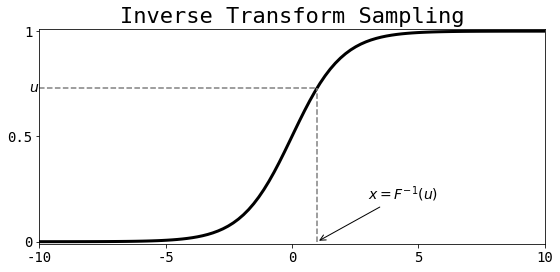

In [3]:
mu = 0
sigma = 1
x = np.linspace(-10,10,100)
cdf_x = logistic_cdf(x, mu, sigma)

fig, ax = plt.subplots(figsize = (8,4))
ax.plot(x, cdf_x, color = 'k', lw=3)
ax.set_title('Inverse Transform Sampling')
x = 1.0
y = logistic_cdf(x, mu, sigma)
ax.plot([-10,x], [y,y], ls = '--', color = '0.5')
ax.plot([x,x], [0,y], ls = '--', color = '0.5')
ax.axis([-10,10, -0.01,1.01])
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1])
grid_x = np.linspace(-10,10,5)
ax.set_xticks(grid_x)
labsx = ax.set_xticklabels([int(xx) for xx in grid_x])
ax.annotate(r"$x = F^{-1}(u)$",
            xy=(x, 0), xycoords='data',
            xytext=(3, 0.2), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
ax.text(-10,y, r"$u$", horizontalalignment = 'right', verticalalignment = 'center')

In [4]:
def logistic_cdf_inverse(y, mu, sigma):
    """
    Return the inverse of the CDF of a logistic random variable
    Inputs:
        y: float: number between 0 and 1
        mu: location parameter
        sigma: scale parameter
    Returns:
        x: the inverse of F(y;mu,sigma)
    """
    inverse_cdf = mu + sigma*np.log(y/(1-y))
    return inverse_cdf

In [5]:
# test the function against Numpy's stats.logistic.ppf()
test_y = 0.2
mu = 10
sigma = 5
my_inv_test = logistic_cdf_inverse(y=test_y, mu=mu, sigma=sigma)
np_inv_test = logistic.ppf(q=test_y, loc=mu, scale=sigma)
assert my_inv_test == np_inv_test
print(test_y, my_inv_test, np_inv_test)

0.2 3.068528194400547 3.068528194400547


In [6]:
def compare_manual_numpy_logistic(mu, sigma, num_draws, seed, ax, diagonal=False, **kwargs):
    """
    Compare the results from using the inverse method and Numpy's own logistic random sample simulator
    using a QQ plot
    inputs:
        mu: location parameter for logistic distribution
        sigma: scale parameter for logistic distribution
        num_draws: integer: number of draws you want to get
        seed: integer: seed of the simulator (good for replication)
        ax: axis object to display QQ plot
        diagonal: bool: If True will display 45 degrees line
        kwargs: for now just color of the plot
    output:
        axis object with QQ plot
    """
    defaultkwargs = {'color':'0.5'}
    if kwargs:
        color = kwargs['color']
    else:
        color = defaultkwargs['color']
    np.random.seed(seed)
    # store everything in a DF
    df_draws = pd.DataFrame(index = range(num_draws), columns = ['uniform','my_draws', 'numpy'])
    df_draws = pd.DataFrame(index = range(num_draws), columns = ['uniform'])
    df_draws['uniform'] = np.random.uniform(low=0, high=1, size=num_draws) # uniform draw
    df_draws['my_draws'] = df_draws.uniform.apply(lambda x: logistic_cdf_inverse(y=x, mu=mu, sigma=sigma))
    df_draws['numpy'] = np.random.logistic(loc=mu, scale=sigma, size=num_draws)
    # Get quantiles and plot 
    quantiles_mine = df_draws.my_draws.quantile(np.linspace(0,1,10)) # deciles
    quantiles_np = df_draws.numpy.quantile(np.linspace(0,1,10)) # deciles
    ax.plot(quantiles_mine, quantiles_np, color = color, ls ='-')
    ax.set_xlabel('My Draws')
    ax.set_ylabel('Numpy')
    ax.set_title('QQ-plot: Numpy random generator vs mine')
    # draw 45 degrees line for comparison
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    if diagonal:
        ax.plot(np.linspace(xmin, xmax, 10), np.linspace(xmin, xmax, 10), ls = '--', color = 'k')
    ax.axis([xmin, xmax, xmin, xmax])
    
    return ax

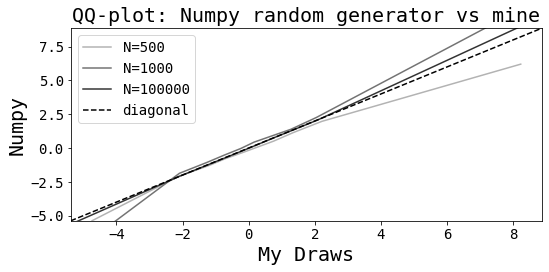

In [7]:
fig, ax = plt.subplots(figsize = (8,4))
draws_grid = [500, 1e3, 1e5]
num_simulations = len(draws_grid)
colors_grid = [f'{np.around(x, decimals=2)}' for x in np.linspace(0.7,0.2,num_simulations)]
for d, draws in enumerate(draws_grid):
    diagonal = False
    if d == num_simulations-1:
        diagonal = True
    ax = compare_manual_numpy_logistic(mu=0, sigma=1, num_draws=int(draws), seed=1345, ax=ax,
                                      diagonal=diagonal, color = colors_grid[d])
leg = ax.legend([f'N={int(x)}' for x in draws_grid]+['diagonal'])
titl = ax.get_title()
titl = ax.set_title(titl, fontsize = 20)

## 2. Linear Models

* Simulate a linear data generating process (DGP), train it on a linear and gradient boosting and compare results.
* Simulate a linear DGP, omit one variable, train it on both linear and GB regression and compare results.

We will simulate a simple linear model with two features.

$$y = \alpha_0 + \alpha_1 x_1 + \alpha_2 x_2 + \epsilon$$


In [8]:
def simulate_normal_linear_model(alpha, vcv_x, var_epsilon, seed, nobs):
    """
    Function to simulate a linear model with normally distributed errors
    Inputs:
        alpha: array with K user-provided coefficients (includes intercept)
        vcv_x: array of dimension (K-1)x (K-1) covariance matrix for X.  Must be positive definite
        var_epsilon: variance for normal errors
        seed: random seed
        nobs: number of observations in the sample
    output: y,X
    """
    np.random.seed(seed)
    K = len(alpha)
    alpha = np.array(alpha).reshape((K,1))   # make it a column vector
    # simulate K-1 normal random: all mean zero (means go to the intercept so it doesn't matter)
    mu = np.array([0]*(K-1)).reshape((K-1,1))
    prex = np.random.multivariate_normal(mean=mu.flatten(), cov=vcv_x, size=nobs)
    ones = np.array([1]*nobs).reshape((nobs,1))  
    X = np.concatenate((ones, prex), axis=1) # include first the column for the intercept
    col_labels = [f'x{num}' for num in range(K)]
    xdf = pd.DataFrame(X, columns = col_labels)
    epsilon = np.sqrt(var_epsilon)*np.random.randn(nobs,1)
    y = np.dot(X, alpha) + epsilon
    ydf = pd.DataFrame(y, columns = ['y'])
    return ydf, xdf

In [9]:
# test it with a trivial example should give 1s: only an intercept =1 and no variance
alpha = [1, 0, 0]  # coefficients
var_x = [0,0]
vcv_x = np.diag(var_x) # this easily ensures positive definiteness
var_epsilon = 0
seed = 44191
nobs = 100
ydf, Xdf = simulate_normal_linear_model(alpha=alpha, vcv_x=vcv_x, var_epsilon=var_epsilon, seed=seed, nobs=nobs)
assert (ydf.y==1).all()

In [10]:
# Now let's get a real model
alpha = [2, 3.5, -5]
var_x = [3,10]
vcv_x = np.diag(var_x)
var_epsilon = 1
seed = 44191
nobs = 100
ydf, Xdf = simulate_normal_linear_model(alpha=alpha, vcv_x=vcv_x, var_epsilon=var_epsilon, 
                                        seed=seed, nobs=nobs)

In [11]:
def run_montecarlo_linear(alpha, vcv_x, var_epsilon, nobs, num_montecarlo, seed_mc, 
                          vars_to_exclude = None):
    """
    Run a Montecarlo simulation with a linear model
    Inputs:
        alpha: array with K user-provided coefficients (includes intercept)
        vcv_x: array of dimension (K-1)x (K-1) covariance matrix for X.  Must be positive definite
        var_epsilon: variance for normal errors
        nobs: number of observations in the sample
        num_montecarlo: number of montecarlo samples
        seed_mc: seed for the seeds of each simulation
        vars_to_exclude: Numpy array of booleans (must be same size as alpha)
            True: exclude that variable, False: include it
            used to simulate omitted variables bias
    output: df_alpha: dataframe with the estimted coefficients (size= num_montecarlo x K)
    """
    # check if excluding variables or not and shapes
    if vars_to_exclude is not None:
        vars_to_exclude = np.array(vars_to_exclude)
        if len(vars_to_exclude) != len(alpha):
            raise ValueError("Vars_to_exclude must have the same dimension as alpha")
    else:
        vars_to_exclude = np.array([False]*len(alpha))
    np.random.seed(seed_mc) # seed for generating a random seed: needed to get different samples
    seed_arr = np.random.randint(low=1, high=10000, size=num_montecarlo, dtype=int)
    K = len(alpha)
    col_labels = [f'x{num}' for num in range(K) if vars_to_exclude[num]==False]
    df_alpha = pd.DataFrame(index = range(num_montecarlo), columns = col_labels)  # initialize df
    for i in range(num_montecarlo):
        ydf, Xdf = simulate_normal_linear_model(alpha=alpha, vcv_x=vcv_x, var_epsilon=var_epsilon, 
                                            seed=seed_arr[i], nobs=nobs)
        Xdf = Xdf[Xdf.columns[vars_to_exclude==False]]
        reg = LinearRegression(fit_intercept=False).fit(Xdf, ydf)  # run regression
        alpha_hat = reg.coef_.flatten()
        df_alpha.loc[i] = alpha_hat
    # convert to float:
    for c, col in enumerate(df_alpha.columns):
        df_alpha[col] = df_alpha[col].astype('float')
        
    return df_alpha

In [12]:
# run an MC simulation with the same parameters as before
num_sims = 300
seed_mc = 3820
df_mc = run_montecarlo_linear(alpha=alpha, vcv_x=vcv_x, var_epsilon=var_epsilon, 
                              nobs=nobs, num_montecarlo=num_sims, seed_mc=seed_mc)
df_mc.head()

,x0,x1,x2
0,1.984162,3.556100,-4.983211
1,1.930668,3.478514,-5.060205
2,1.884682,3.406333,-4.988375
3,1.957790,3.486812,-5.002013
4,2.113126,3.426713,-4.971911


In [13]:
# let's plot the results
def plot_boxplot(df, ax, iq_bool = False, qmin=0.05, qmax = 0.95, true_params = None):
    """
    Plot interquartile range (median and mean can be easily accomodated if wanted)
    Inputs: 
        df: dataframe with results from MonteCarlo
        ax: axis object
        iq_bool: Boolean: True if Interquartile Range, False: if Conf. Intevals
        qmin, qmax: quantiles for two-sided hypothesis test (default: 10% CI)
        true_params: array with true parameters if I want to plot them along
    Output:
        axis object with the box plot and true parameters
        """
    if iq_bool:
        qmin, qmax = 0.25, 0.75
    # compute some quantiles and the mean
    mean_alpha = df.mean()
    quant_alpha = df.quantile([qmin, qmax])
    
    num_coef = df.shape[1]  # number of coefficients
    bottom = np.array([np.nan]*num_coef)
    height = np.array([np.nan]*num_coef)
    bottom = quant_alpha.min()
    height = quant_alpha.max()-quant_alpha.min()
    width = 0.8
    # plot interquartile range
    ax.bar(range(num_coef), bottom=bottom, height=height, edgecolor ='k', facecolor='w', 
           alpha = 0.5, width=width)
    # plot means as a line
    len_mean = width*0.6
    for i in range(num_coef):
        ax.plot([i - len_mean, i + len_mean], [mean_alpha[i], mean_alpha[i]], color='k', lw=2)
    xmin, xmax = ax.get_xlim()
    ax.plot([xmin, xmax], [0, 0], ls = '--', color = '0.75')
    ax.set_xlim([xmin,xmax])
    if true_params is not None:
        # plot true params as a marker
        ax.scatter(range(num_coef), true_params, marker = 's', color = 'k', s=20)
    # save a dictionary to plot
    dict_res = {'ax' : ax, 
                'mean_params' : mean_alpha,
                'quant_params' : quant_alpha,
                'true_params' : true_params
               }
    return dict_res

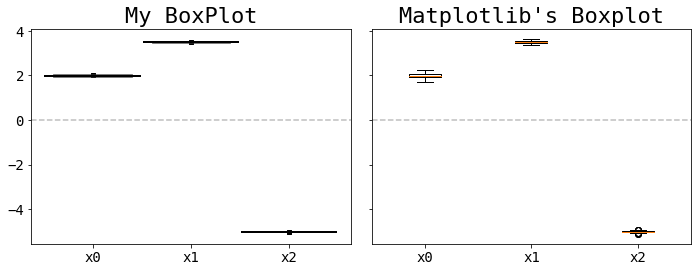

In [14]:
# try a Box Plot of the results and compare with Matplotlib's own Boxplot method

fig, ax = plt.subplots(1,2, sharey = True)
dict_ax = plot_boxplot(df=df_mc, ax=ax[0], iq_bool = True, true_params = alpha)
ax[0] = dict_ax['ax']
ax[0].set_title('My BoxPlot')
ax[0].set_xticks(range(df_mc.shape[1]))
ax[0].set_xticklabels(df_mc.columns)
# compare to Matplotlib's Boxplot
dum = ax[1].boxplot(df_mc.values)
ax[1].set_title("Matplotlib's Boxplot")
ax[1].set_xticklabels(df_mc.columns)
xmin, xmax = ax[1].get_xlim()
ax[1].plot([xmin, xmax], [0,0], ls = '--', color = '0.75')

**Note**: I don't really care about the interquartile range in the Box Plot.  I care about confidence intervals.

Next functions create a simplified plot to present the results

In [15]:
def percentile(n):
    """
    Percentile function to pass to Pandas agg method
    Taken from: https://stackoverflow.com/questions/17578115/pass-percentiles-to-pandas-agg-function
        Note that top answer doesn't work well to handle multiple columns so I used a proposed fix in
        the thread (Thomas) that uses Pandas quantile method that works on any series
    """
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:2.0f}'.format(n*100)
    return percentile_

def create_means_bounds_mc(df, qmin = 0.05, qmax = 0.95):
    """
    Helper function to get the means and bounds for the plot_conf_intervals method
    df: dataframe with the results from the MonteCarlo simulation
    qmin, qmax: quantiles to create the CI (default is 90% CI)
    """
    df_agg = df.agg([np.mean, percentile(qmin), percentile(qmax)])
    return df_agg

def plot_conf_intervals(means, bounds, var_labels, ax, true_params = None, plot_bars = True):
    """
    Plot standard confidence intervals.  Box plots do the job, but this is more general function
        means: array: has the means to be plotted (could be estimated parameters)
        bounds: array: lower and upper bounds for the CI (size: 2 x number of columns)
        var_labels: 
        ax: axis object to create the plot
        true_params: array with true parameters if I want to plot them along (default: None)
        plot_bars: Boolean: if True: plot the bars, False: just plot the CI and means as marker
            Bars may unnecessarily clutter the plot (see first example below)
    Output:
        axis object with the plot
    """
    # check dimensions first
    if len(means)!=bounds.shape[1] or len(var_labels)!=len(means):
        raise ValueError("You must pass the same number of variables for means and bounds")
    # plot means as bars, confidence intervals as lines
    n_bars = len(means)
    width = 0.5
    G = 0.2*width # parameter to control the width of the CI
    if plot_bars:
        ax.bar(range(n_bars), means, color ='0.75', edgecolor = 'k', width = width, alpha = 0.5, 
              label='means')
    else:
        #x_scatter = [i-G*0.5 for i in range(n_bars)]
        #ax.scatter(x_scatter, means, color = '0.5', edgecolor = 'k', marker = '.', s = 30, 
        #      label='means')
        for i in range(n_bars):
            if i==0:
                ax.plot([i-G*0.5, i+G*0.5], [means[i], means[i]], color='k',ls='--', label='means')
            else:
                ax.plot([i-G*0.5, i+G*0.5], [means[i], means[i]], color='k',ls='--')
                
    for i in range(n_bars):
        ymin_i, ymax_i = bounds[:,i]
        if i==0:
            ax.plot([i, i], [ymin_i, ymax_i], color ='k', alpha = 0.5, label='CI')
        else:
            ax.plot([i, i], [ymin_i, ymax_i], color ='k', alpha = 0.5)
        ax.plot([i-G, i+G], [ymin_i, ymin_i], color ='k', alpha = 0.5, lw = 1)
        ax.plot([i-G, i+G], [ymax_i, ymax_i], color ='k', alpha = 0.5, lw = 1)
    # pass labels
    ax.set_xticks(range(n_bars))
    ax.set_xticklabels(var_labels)
    # plot true parameters
    if true_params is not None:
        x_scatter_p = [i+G*0.5 for i in range(n_bars)]  # to improve visibility
        ax.scatter(x_scatter_p, true_params, marker = 's', color = 'k', s=30,
              label='true')
        
    xmin, xmax = ax.get_xlim()
    ax.plot([xmin, xmax], [0, 0], ls = '--', color = '0.2')
    ax.set_xlim([xmin, xmax]) # just to make the plot nicer: enforce plot's width
    ax.legend()
    return ax

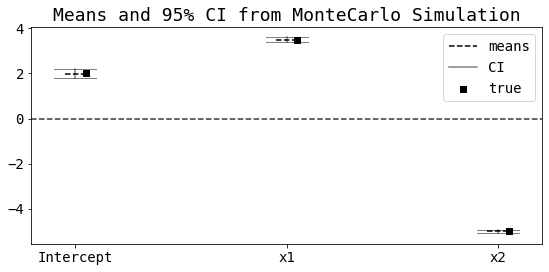

In [16]:
bounds_sn = create_means_bounds_mc(df=df_mc, qmin=0.025, qmax=0.975)
means = bounds_sn.loc['mean']
ind_ptile = [ind for ind in bounds_sn.index if ind.find('percentile') >= 0]
bounds = bounds_sn.loc[ind_ptile].values
var_labels = ['Intercept', 'x1', 'x2']

fig, ax = plt.subplots(figsize=(8,4))
ax = plot_conf_intervals(means=means, bounds=bounds, var_labels=var_labels, ax=ax, true_params=alpha,
                        plot_bars=False)
title = ax.set_title('Means and 95% CI from MonteCarlo Simulation', fontsize = 18)

## 3. Decrease _signal to noise ratio_ 

In general, the [signal to noise ratio](https://en.wikipedia.org/wiki/Signal-to-noise_ratio) is the ratio of the variance of the model relative to random noise.  The "model" for us is a combination of two things: (i) features used, and (ii) their combination through a linear or non-linear function.

We can easily increase the signal-to-noise ratio by simulating residuals with larger variance, leaving the variance of the features fixed.

In [17]:
# run an MC simulation with the same parameters as before
num_sims = 300
seed_mc = 10621
var_epsilon = 1000  # note how I increased the variance of the residuals
df_mc1000 = run_montecarlo_linear(alpha=alpha, vcv_x=vcv_x, var_epsilon=var_epsilon, 
                              nobs=nobs, num_montecarlo=num_sims, seed_mc=seed_mc)


**Learnings**:
* OLS are reliable: true parameters and means are essentially the same (horizontal lines and markers)
* But lower _signal to noise_ ratio made the estimates _less precise_.  You can see that CI for the intercept and x1 cross the zero line.

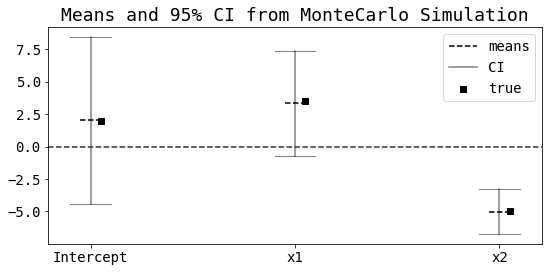

In [18]:
bounds_sn = create_means_bounds_mc(df=df_mc1000, qmin=0.025, qmax=0.975)
means = bounds_sn.loc['mean']
ind_ptile = [ind for ind in bounds_sn.index if ind.find('percentile') >= 0]
bounds = bounds_sn.loc[ind_ptile].values
var_labels = ['Intercept', 'x1', 'x2']

fig, ax = plt.subplots(figsize=(8,4))
ax = plot_conf_intervals(means=means, bounds=bounds, var_labels=var_labels, ax=ax, true_params=alpha,
                        plot_bars=False)
title = ax.set_title('Means and 95% CI from MonteCarlo Simulation', fontsize = 18)

## 4. Understanding Partial Dependence Plots (PDP)

I want to show: 
* How to create PDPs for nonlinear models
* How they map to coefficients of a linear model

### In linear regression coefficients are the marginal effect:

$$
y = \alpha_0 + \alpha_1 x_1 + \alpha_2 x_2 + \epsilon
$$

So

$$
\frac{\partial E(y | X)}{\partial x_k} = \alpha_k
$$

In words:

If `xk` increases by one unit, we expect `y` to increase by `alpha k` units

Linear regression is great for interpretability because of this.  But it's predictive performance isn't great.  That's why we use more powerful algorithms.

For non-linear models we can get a sense of the change in the outcome associated to changes in each feature from PDPs

The next functions will create a PDP.

In [19]:
def find_categorical_variables(xdf):
    """This function automates finding categorical/dummy variables
    Inputs:
        xdf: dataframe with the features used in training a model
    Outputs:
        df_counts: a mapping of each feature in Xdf with it's type
    """
    # first step: find those that might be dummies numerically 
    # This is important for binary dummies: for non-binary we need to be careful
    xcols = xdf.columns
    # get first a mapping of feature --> type
    # Idea: count distinct values.  If more than 2 --> continuous (numerical)
    df_counts = pd.DataFrame(index = xcols, columns = ['counts','type','modal'])
    for c, col in enumerate(xcols):
        prec = xdf[col].value_counts()
        len_ix = len(prec.index)
        df_counts['counts'].loc[col] = len_ix
        # map to type and include the modal or mean for later use
        if len_ix >= 3:
            df_counts.type.loc[col] = 'numerical'
            mode_val = xdf[col].mean()
        elif len_ix == 1:
            df_counts.type.loc[col] = 'intercept'
            mode_val = prec.index[0]
        else:
            df_counts.type.loc[col] = 'categorical'
            mode_val = prec.index[0]
        df_counts['modal'].loc[col] = mode_val
    
    return df_counts

  

In [20]:
# Let's simulate a linear model
alpha = [2, 3.5, -5]
var_x = [3,10]
vcv_x = np.diag(var_x)
var_epsilon = 1
seed = 21671
nobs = 100
ydf, Xdf = simulate_normal_linear_model(alpha=alpha, vcv_x=vcv_x, var_epsilon=var_epsilon, 
                                        seed=seed, nobs=nobs)

In [21]:
test_cat = find_categorical_variables(xdf = Xdf)
test_cat

,counts,type,modal
x0,1,intercept,1
x1,100,numerical,-0.20103
x2,100,numerical,0.293603


In [22]:
def create_pdp(xdf, name_var, model, drop_outliers = True, pmin = 0.01, pmax = 0.99, 
                   dict_specific_xs = None):
    """
    Create a partial dependence plot dataset: this function doesn't plot the results
    It creates a grid for the selected variable (name_var) and all other variables are evaluated
        on the means.
    Inputs:
        xdf: to get the means
        var_to_simulate: specific var to create a grid (if binary, I need to take care of dummy variables)
        model: model object from scikitlearn regression
        drop_outliers: Bool: if True we first drop outliers before creating grid
        pmin, pmax: percentiles to define what an outlier is
        dict_specific_xs: Dictionary if user want's to evaluate on other value {feature:value}
            This is useful when you want to evaluate on something different than the mean
            or when you want to get "interaction effects" in the partial dependence plot
    Outputs:
        y_pred: dataframe with the PDP
        flag_line: Boolean: True if line plot (numerical feature), False if bar plot (dummy variable)
    """
    # 1.  check if I have categorial data
    prelab = find_categorical_variables(xdf)
    cols_cat = prelab.index[prelab.type == 'categorical']
    cols_int = prelab.index[prelab.type == 'intercept']
    # 2. Create grid for name_var but first drop outliers
    flag_line = True  # default plot is line, except for dummy variables (bar)
    if name_var in cols_cat: # dummy variables
        grid_size = 2
        lin_grid = np.array([0]*int(grid_size/2) + [1]*int(grid_size/2))
        flag_line = False
    elif name_var in cols_int:  # intercept
        grid_size = 1
        lin_grid = np.array([1])
        flag_line = False
    else:  # continuous
        grid_size = 20
        if drop_outliers == False:  # if no outlier dropping, set to min, max to 0,1
            pmin, pmax = 0, 1
        lin_grid = xdf[name_var].quantile(np.linspace(pmin, pmax, grid_size))
    # 2. create matrix of means <-- change this if you want to evaluate on median or else
    means_array = xdf.mean().values
    df_mean = pd.DataFrame(np.tile(means_array, (grid_size,1)), columns=xdf.columns, index=lin_grid)
    for c, col in enumerate(cols_cat):
        df_mean[col] = prelab.loc[col].modal
    # 3. replace in X and predict
    df_mean[name_var] = df_mean.index
    # 4. replace any specific Xs we have
    if dict_specific_xs is not None:
        for col in dict_specific_xs:
            df_mean[col] = dict_specific_xs[col]

    # 5. Use trained model to make a prediction on df_mean
    y_pred = pd.DataFrame(model.predict(df_mean), columns = ['score'], index = lin_grid)

    return y_pred, flag_line

In [23]:
def plot_pdp(xdf, name_var, model, ax, ydf_string = 'Score', drop_outliers = False, 
             pmin = 0, pmax = 1, **kwargs):
    """
    Plot PDP using the output from create_pdp
    Inputs:
        name_var --> String: to select the feature that needs to be simulated
        xdf: matrix of features to create grid and simulation
        model: model object to be used from SCIKIT-LEARN
        ax: axis object to create plot
        ydf_string: string for title
        drop_outliers = True: if False: keep whole data, if True: cut the tails of the distribution
        pmin, pmax: percentiles to control extreme observations in the pdp
        kwargs: right now only line style
    Output:
        ax: axis object with plot
        y_pred: dataframe with the current variable's grid  and predicted values of Y
        flag_line: useful for debugging to check if a categorical variable was wrongly labeled as continuous
            or viceversa
    """
    # set default kwargs
    ls = '-'
    if kwargs:
        if 'ls' in kwargs.keys():
            ls = kwargs['ls']
    # get prediction 
    y_pred, flag_line = create_pdp(xdf, name_var, model, drop_outliers=drop_outliers, pmin=pmin, pmax=pmax,
                                   dict_specific_xs = None)
    # plot
    kind_plot = 'bar'
    color = '0.7'
    if flag_line:
        kind_plot = 'line'
        color = 'k'
        y_pred.plot(ax = ax, kind = kind_plot, color = color, alpha=0.9, ls=ls)
    else:
        y_pred.plot(ax = ax, kind = kind_plot, color = color, alpha=0.9, ls=ls)
    ax.legend().remove()
    ax.set_title(f'PDP for {name_var}')
    ax.set_xlabel(name_var)
    ax.set_ylabel('Yhat')
    return ax, y_pred, flag_line



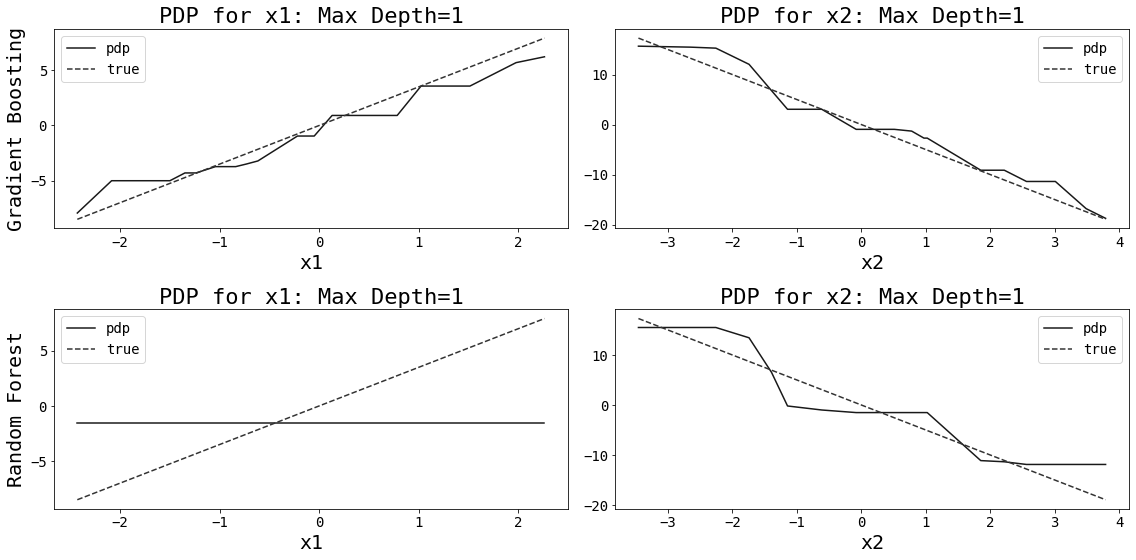

In [24]:
# test with GB and RF
max_depth = 1
mod = GradientBoostingRegressor(random_state=1089, max_depth = max_depth)
mod.fit(Xdf, ydf.values.flatten())
modrf = RandomForestRegressor(random_state=1089, max_depth = max_depth)
modrf.fit(Xdf, ydf.values.flatten())
dict_mod = {0:mod, 1:modrf}
dict_ttl = {0:'Gradient Boosting', 1:'Random Forest'}
# plot
fig, ax = plt.subplots(2, 2, figsize = (16,8))
for m in range(2):
    mod_m = dict_mod[m]
    for c, col in enumerate(Xdf.columns[1:]):
        ax[m,c], y_c, flag_c = plot_pdp(xdf=Xdf, name_var=col, model=mod_m, ax=ax[m,c], ydf_string = col, 
                                      drop_outliers = True, pmin=0.1, pmax=0.9, ls='-')
        # let's plot the true effect also: ak*xk
        true_c = y_c.index.values*alpha[c+1]
        ax[m,c].plot(y_c.index, true_c, color = '0.2', ls = '--')
        ttl_m = ax[m,c].get_title()
        ttl_m = ax[m,c].set_title(f'{ttl_m}: Max Depth={max_depth}')
        ax[m,c].legend(['pdp','true'])
        if c==0:
            ax[m,c].set_ylabel(dict_ttl[m])
        else:
            ax[m,c].set_ylabel('')
        

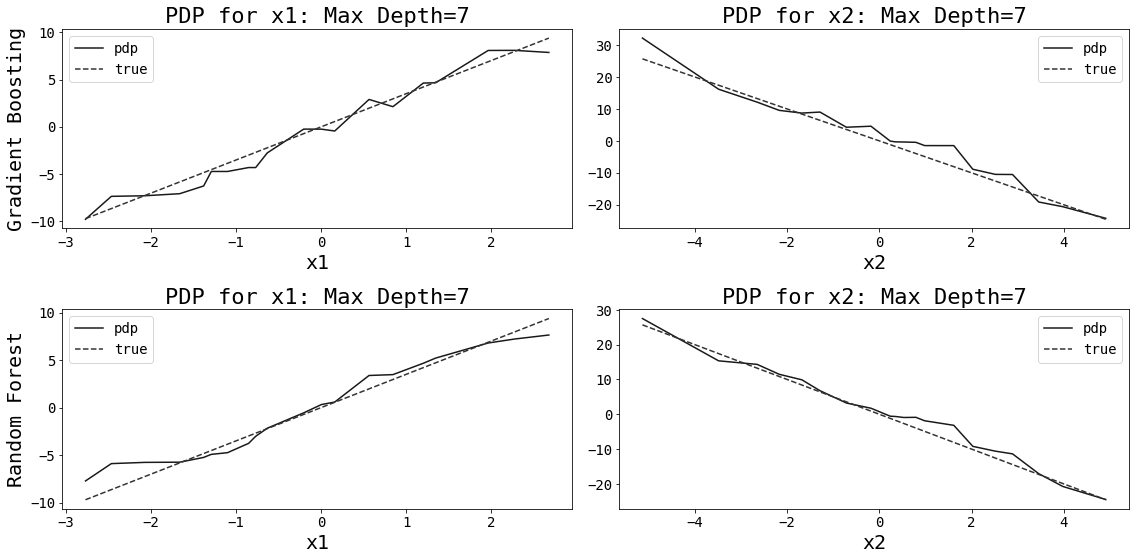

In [25]:
# test with GB and RF
max_depth = 7
mod = GradientBoostingRegressor(random_state=1089, max_depth = max_depth)
mod.fit(Xdf, ydf.values.flatten())
modrf = RandomForestRegressor(random_state=1089, max_depth = max_depth)
modrf.fit(Xdf, ydf.values.flatten())
dict_mod = {0:mod, 1:modrf}
dict_ttl = {0:'Gradient Boosting', 1:'Random Forest'}
# plot
fig, ax = plt.subplots(2, 2, figsize = (16,8))
for m in range(2):
    mod_m = dict_mod[m]
    for c, col in enumerate(Xdf.columns[1:]):
        ax[m,c], y_c, flag_c = plot_pdp(xdf=Xdf, name_var=col, model=mod_m, ax=ax[m,c], ydf_string = col, 
                                      drop_outliers = True, pmin=0.05, pmax=0.95, ls='-')
        # let's plot the true effect also: ak*xk
        true_c = y_c.index.values*alpha[c+1]
        ax[m,c].plot(y_c.index, true_c, color = '0.2', ls = '--')
        ttl_m = ax[m,c].get_title()
        ttl_m = ax[m,c].set_title(f'{ttl_m}: Max Depth={max_depth}')
        ax[m,c].legend(['pdp','true'])
        if c==0:
            ax[m,c].set_ylabel(dict_ttl[m])
        else:
            ax[m,c].set_ylabel('')
        

### What's going on here?  Why do we need more depth in RF than GB?

* In this simulation a change in `x2` has more "weight"
    * `x2` has larger variance (`var(x2) = 10 > 3 = var(x1`)
    * And the absolute value of the slope parameter is larger (5 vs. 3.5)
    * So a one std change in `x2` has a larger impact on `y` than a corresponding change in `y`
    * In RF: this means that `x2` is more likely to be selected in the first split-point for any RF tree in the ensemble
    * Below two further examples: 
        * Try to force RF to give `x1` a higher chance of being chosen (`max_features`)
        * Switch the variances to show the impact of (10--> 3 and viceversa)

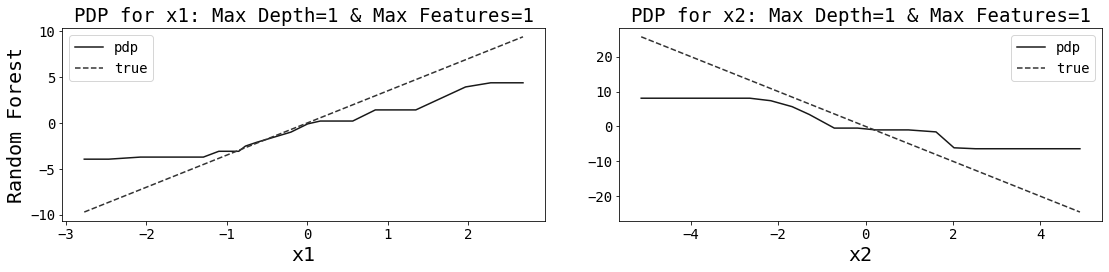

In [26]:
# Change a max_features meta parameter to 
max_depth = 1
max_features = 1
modrf = RandomForestRegressor(random_state=1089, max_depth = max_depth, max_features=max_features)
modrf.fit(Xdf, ydf.values.flatten())
# plot
fig, ax = plt.subplots(1, 2, figsize = (16,4))
for c, col in enumerate(Xdf.columns[1:]):
    ax[c], y_c, flag_c = plot_pdp(xdf=Xdf, name_var=col, model=modrf, ax=ax[c], ydf_string = col, 
                                  drop_outliers = True, pmin=0.05, pmax=0.95, ls='-')
    # let's plot the true effect also: ak*xk
    true_c = y_c.index.values*alpha[c+1]
    ax[c].plot(y_c.index, true_c, color = '0.2', ls = '--')
    ttl_m = ax[c].get_title()
    ttl_m = ax[c].set_title(f'{ttl_m}: Max Depth={max_depth} & Max Features={max_features}', fontsize =19)
    ax[c].legend(['pdp','true'])
    if c==0:
        ax[c].set_ylabel(dict_ttl[m])
    else:
        ax[c].set_ylabel('')


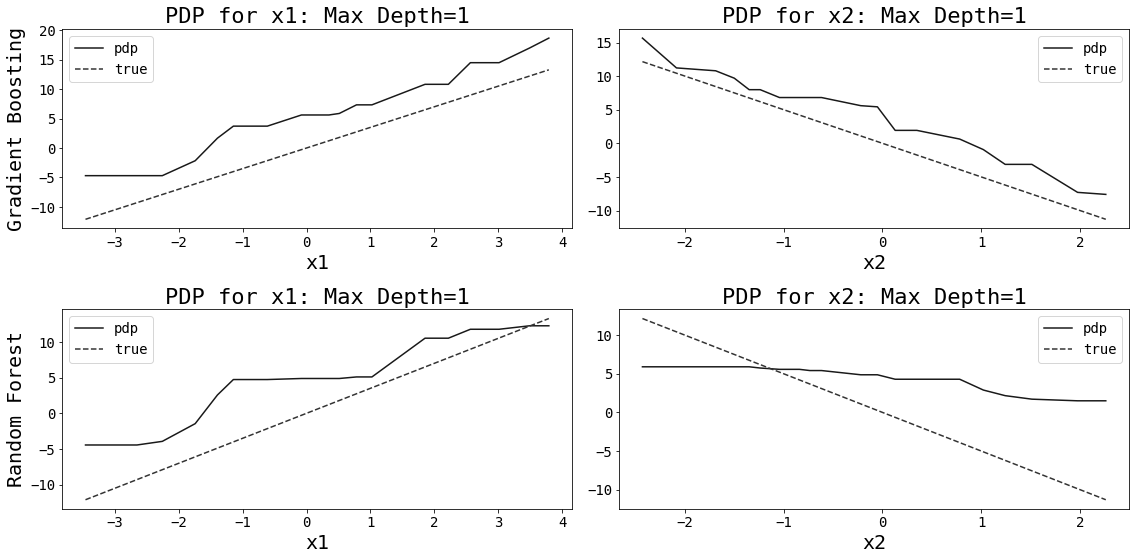

In [27]:
# Switch the variance of the features
var_x1 = [10,3]
vcv_x1 = np.diag(var_x1)
ydf, Xdf = simulate_normal_linear_model(alpha=alpha, vcv_x=vcv_x1, var_epsilon=var_epsilon, 
                                        seed=seed, nobs=nobs)

# plot
# test with GB and RF
max_depth = 1
mod = GradientBoostingRegressor(random_state=1089, max_depth = max_depth)
mod.fit(Xdf, ydf.values.flatten())
modrf = RandomForestRegressor(random_state=1089, max_depth = max_depth)
modrf.fit(Xdf, ydf.values.flatten())
dict_mod = {0:mod, 1:modrf}
dict_ttl = {0:'Gradient Boosting', 1:'Random Forest'}
# plot
fig, ax = plt.subplots(2, 2, figsize = (16,8))
for m in range(2):
    mod_m = dict_mod[m]
    for c, col in enumerate(Xdf.columns[1:]):
        ax[m,c], y_c, flag_c = plot_pdp(xdf=Xdf, name_var=col, model=mod_m, ax=ax[m,c], ydf_string = col, 
                                      drop_outliers = True, pmin=0.1, pmax=0.9, ls='-')
        # let's plot the true effect also: ak*xk
        true_c = y_c.index.values*alpha[c+1]
        ax[m,c].plot(y_c.index, true_c, color = '0.2', ls = '--')
        ttl_m = ax[m,c].get_title()
        ttl_m = ax[m,c].set_title(f'{ttl_m}: Max Depth={max_depth}')
        ax[m,c].legend(['pdp','true'])
        if c==0:
            ax[m,c].set_ylabel(dict_ttl[m])
        else:
            ax[m,c].set_ylabel('')
        

## 5. Omitted Variables

In OLS there's [omitted variables bias](https://en.wikipedia.org/wiki/Omitted-variable_bias): if you exclude a relevant feature, your estimates are biased.  A natural question is: are other ML algorithms also sensitive to omitted variables?

Let's show:
* The extent of omitted variables with OLS and GB regression
* Omitted vars don't matter when features are _independent_
* But they matter a lot with _correlated_ features

In [28]:
# run an MC simulation with the same parameters as before
# I'll start with Linear Regression:
# Example 1: independent features
num_sims = 300
seed_mc = 52128
var_epsilon = 1
# exclude the last variable (with coefficient -5)
alpha = [2, 3.5, -5]
var_x = [3,10]
vcv_x = np.diag(var_x) # since VCV is diagonal --> x1 and x2 are independent
vars_to_exclude = np.array(alpha) == -5
nobs = 100
# MC excluding the last variable
df_mc_omitted = run_montecarlo_linear(alpha=alpha, 
                                      vcv_x=vcv_x, 
                                      var_epsilon=var_epsilon, 
                                      nobs=nobs, 
                                      num_montecarlo=num_sims, 
                                      seed_mc=seed_mc, 
                                      vars_to_exclude = vars_to_exclude)

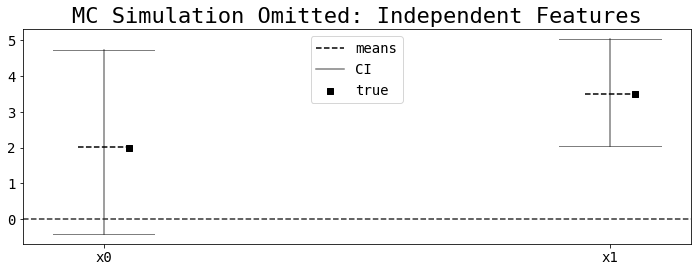

In [29]:
params_omitted = create_means_bounds_mc(df = df_mc_omitted, qmin = 0.05, qmax = 0.95)
means_om = params_omitted.loc['mean']
ind_ptile = [ind for ind in params_omitted.index if ind.find('percentile') >= 0]
bounds_om = params_omitted.loc[ind_ptile].values
var_labels = params_omitted.columns
true_included = [val for a,val in enumerate(alpha) if vars_to_exclude[a] == False]
# plot
fig, ax = plt.subplots()
ax = plot_conf_intervals(means=means_om, bounds=bounds_om, var_labels=var_labels, ax=ax, 
                            true_params = true_included,
                            plot_bars=False)
title = ax.set_title('MC Simulation Omitted: Independent Features')

#### Learnings from above MC simulation:
* With independent features there's no bias.  CI for the intercept are very large, but estimates are right.

Correlation coefficient = -0.3797173122893929


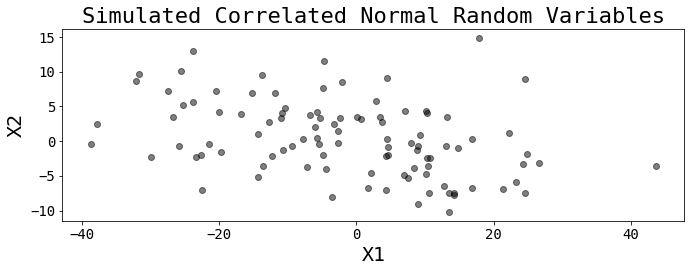

In [30]:
# let's repeat for correlated features
# Variance covariance matrix for X must be positive definite matrix: for any A, then A*A' is pos def
# let's test this first:
a11 = 3
a12 = -15
a21 = -5
a22 = 1
pre_vcv = np.array([[a11, a12],[a21, a22]]) # a given 2x2 matrix (you can change the params)
vcv_x1 = np.dot(pre_vcv, pre_vcv.T)
np.random.seed(20511)
#vcv_x = np.diag([10,20])
test_x = np.random.multivariate_normal(mean=np.array([0,0]), cov=vcv_x1, size=nobs)
# plot the two variables
fig, ax = plt.subplots(figsize = (10,4))
ax.scatter(test_x[:,0],test_x[:,1], color = 'k', alpha = 0.5, edgecolor = 'k')
corr_12 = np.corrcoef(test_x, rowvar=False)
print(f'Correlation coefficient = {corr_12[1,0]}')
ax.set_title('Simulated Correlated Normal Random Variables')
xlab = ax.set_xlabel('X1')
ylab = ax.set_ylabel('X2')

In [31]:
# run an MC simulation with the same parameters as before
# Example 1: independent features
num_sims = 300
seed_mc = 12158
var_epsilon = 1
# exclude the last variable (with coefficient -5)
alpha = [2, 3.5, -5]
vars_to_exclude = np.array(alpha) == -5
# MC excluding the last variable
df_mc_omitted_corr = run_montecarlo_linear(alpha=alpha, 
                                      vcv_x=vcv_x1, 
                                      var_epsilon=var_epsilon, 
                                      nobs=nobs, 
                                      num_montecarlo=num_sims, 
                                      seed_mc=seed_mc, 
                                      vars_to_exclude = vars_to_exclude)

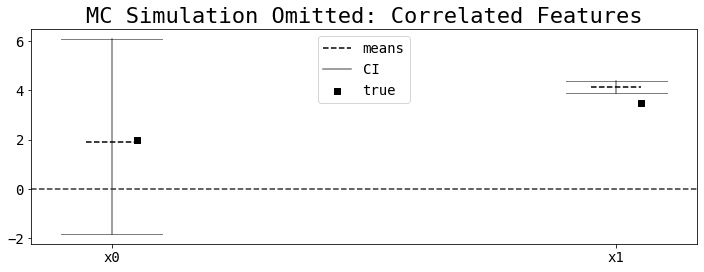

In [32]:
# Note how correlated features bias the estimate for x1!
params_omitted_corr = create_means_bounds_mc(df = df_mc_omitted_corr, qmin = 0.05, qmax = 0.95)
means_om_c = params_omitted_corr.loc['mean']
ind_ptile = [ind for ind in params_omitted_corr.index if ind.find('percentile') >= 0]
bounds_om_c = params_omitted_corr.loc[ind_ptile].values
var_labels = params_omitted_corr.columns
# plot
fig, ax = plt.subplots()
ax = plot_conf_intervals(means=means_om_c, bounds=bounds_om_c, var_labels=var_labels, ax=ax, 
                            true_params = true_included,
                            plot_bars=False)
leg = ax.get_legend()
leg._set_loc(9)
title = ax.set_title('MC Simulation Omitted: Correlated Features')

You can see the extent of bias now:

* `x1` is correlated with the omitted variable
* The true parameter is outside of the CI from the MC simulation (as expected)

I'll now show the extent of the bias for different correlation parameters

In [33]:
def compute_vcv(rho):
    """
    Given a correlation parameter between x1 and x2 (omitted) calculate the vcv to get draws
        This function really simplifies the calculation making the VCV a function only of
        the correlation.  I force the variances to be 1 to have a unique free parameter.
    Inputs:
        rho: float between -1,1: correlation between x1 and x2
    Output:
        vcv: array with variance covariance matrix
    """
    # covariance parameters
    a11 = 1
    a12 = rho
    a21 = rho
    a22 = 1
    vcv = np.array([[a11, a12],[a21, a22]]) # a given 2x2 matrix (you can change the params)
    return vcv

In [34]:
def simulate_2random_correlated(nobs, seed, rho, ax):
    """
    Simulate random normal correlated variables indexed by correlation coefficient rho
    Plot the results as a scatterplot
    """
    np.random.seed(seed)
    vcv = compute_vcv(rho)
    x_corr = np.random.multivariate_normal(mean=np.array([0,0]), cov=vcv, size=nobs)
    # plot the two variables
    ax.scatter(x_corr[:,0],x_corr[:,1], color='k', alpha = 0.5)
    ax.set_title(f'Simulated R.V (rho = {rho})')
    xlab = ax.set_xlabel('X1')
    ylab = ax.set_ylabel('X2')
    return ax

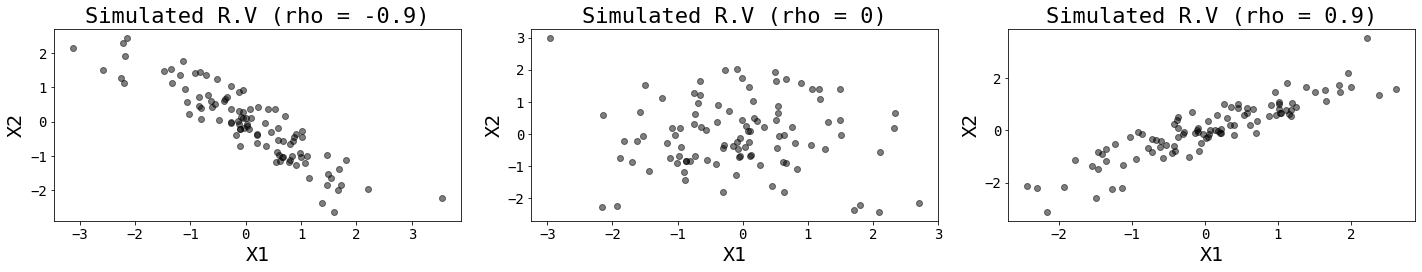

In [35]:
# let's test the function with three different correlation parameters
rho_arr = [-0.9, 0, 0.9]
fig, ax = plt.subplots(1,3, figsize=(20,4))
nobs = 100
seed = 13513
for i in range(3):
    ax[i] = simulate_2random_correlated(nobs, seed, rho = rho_arr[i], ax = ax[i])

In [36]:
def calculate_bias_omitted(rho,alpha, var_epsilon, nobs, num_sims, seed_mc, vars_to_exclude):
    """
    Calculate Bias = true - mean(param) as a function of the correlation between included and omitted
        This function only works for a 2-vars example.
        Bias = true parameter - E(estimated parameter)
    Inputs:
        rho: float in [-1,1]: correlation coefficient between x1 and x2 (omitted)
        Other inputs: same as run_montecarlo_linear
    Output:
        bias: pd.Series of bias for included variables
        
    """
    # compute VCV matrix
    vcv_x = compute_vcv(rho)
    # run simulation
    df_mc_simu = run_montecarlo_linear(alpha=alpha, 
                                      vcv_x=vcv_x, 
                                      var_epsilon=var_epsilon, 
                                      nobs=nobs, 
                                      num_montecarlo=num_sims, 
                                      seed_mc=seed_mc, 
                                      vars_to_exclude = vars_to_exclude)
    # compute bias: E(theta)-True(theta)
    mean_x = df_mc_simu.mean()
    alpha_inc = [val for a,val in enumerate(alpha) if vars_to_exclude[a] == False]
    bias = mean_x - alpha_inc
    return bias

**Test with independent features**: I should get negligible bias

In [37]:
num_sims = 300
seed_mc = 14548
var_epsilon = 1
nobs = 100
# exclude the last variable (with coefficient -5)
alpha = [2, 3.5, -5]
vars_to_exclude = np.array(alpha) == -5
test_bias = calculate_bias_omitted(rho = 0,
                                   alpha = alpha, 
                                   var_epsilon = var_epsilon, 
                                   nobs = nobs, 
                                   num_sims = num_sims, 
                                   seed_mc = seed_mc, 
                                   vars_to_exclude = vars_to_exclude)

# with rho = 0 we should have negligible bias
print(f"Bias for x1 (independent features): {np.around(test_bias.loc['x1'], decimals=3)}")

Bias for x1 (independent features): -0.003


#### I can now iterate over a grid of correlation coefficients

In [38]:
# iterate over a linear grid of correlation coefficients between x1 and ommitted x2
rho_array = np.linspace(-1,1.0000000001,10)
alpha = [2, 3.5, -5]
df_bias = pd.DataFrame(index = rho_array, columns = ['x0', 'x1'])
for r, my_rho in enumerate(rho_array):
    bias_r = calculate_bias_omitted(rho = my_rho,
                                   alpha = alpha, 
                                   var_epsilon = var_epsilon, 
                                   nobs = nobs, 
                                   num_sims = num_sims, 
                                   seed_mc = seed_mc, 
                                   vars_to_exclude = vars_to_exclude)
    df_bias.loc[my_rho] = bias_r


### Plot below: bias for x0 and x1 as a function of correlation

Learnings:
* Intercept: since intercept and x2 (omitted) is zero, there's no bias
* `x1`: note that bias is monotically increasing in the correlation coefficient and zero if they are independent.

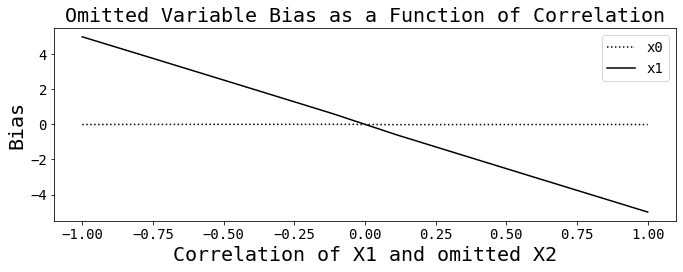

In [39]:
fig, ax = plt.subplots()
ls_lst = ['dotted', 'solid']
for c, col in enumerate(df_bias.columns):
    df_bias[col].plot(ax = ax, color = 'k', ls = ls_lst[c])
ax.set_title('Omitted Variable Bias as a Function of Correlation', fontsize = 20)
leg = ax.legend(['x0','x1'])
ylab = ax.set_ylabel('Bias')
xlab = ax.set_xlabel('Correlation of X1 and omitted X2')

### Let's check partial dependence plots for Gradient Boosting regression

* I want to show the impact of bias if we use Gradient Boosting or Random Forests
* I'll use the PDPs from above

Bias for depth = 1 = -0.453
Bias for depth = 3 = -0.848
Bias for depth = 5 = -0.807


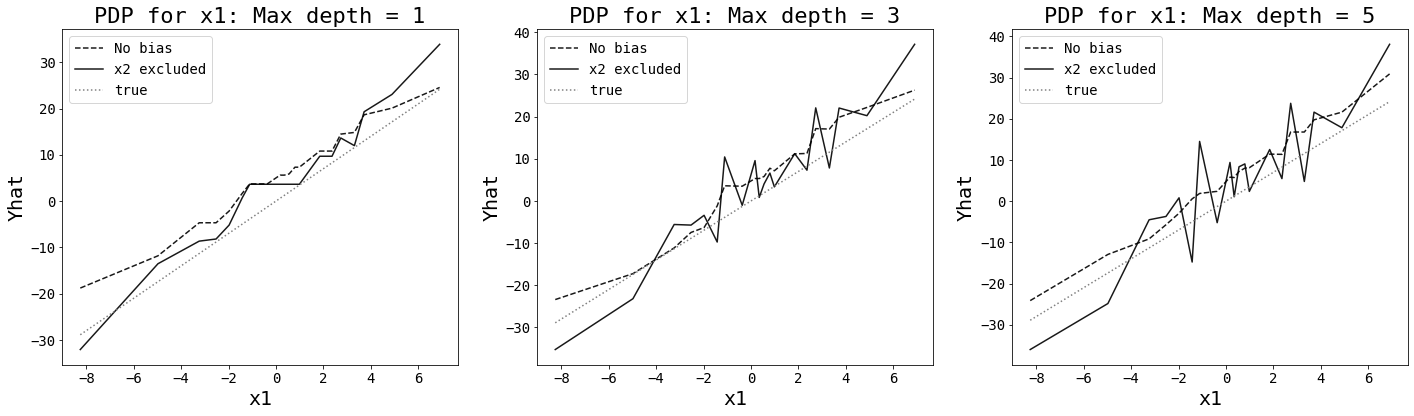

In [40]:
# Compute bias with excluded and non-excluded
depth_grid = [1,3,5]
cols_bias = ['x0','x1']
cols_nobias = ['x0','x1','x2']
fig, ax = plt.subplots(1,len(depth_grid),figsize = (20,6))
for d, depth in enumerate(depth_grid):
    # GBM no bias: I include everything
    mod_nobias = GradientBoostingRegressor(random_state=1089, max_depth = depth)
    mod_nobias.fit(Xdf[cols_nobias], ydf.values.flatten())
    # GBM bias: only x0 and x1
    mod_bias = GradientBoostingRegressor(random_state=1089, max_depth = depth)
    mod_bias.fit(Xdf[cols_bias], ydf.values.flatten())
    # Plot
    ax[d], y_nb, flag_nb = plot_pdp(xdf=Xdf[cols_nobias], name_var='x1', model=mod_nobias, ax=ax[d], 
                                    ydf_string = 'x1', drop_outliers = True, ls = '--')
    # bias
    ax[d], y_b, flag_b = plot_pdp(xdf=Xdf[cols_bias], name_var='x1', model=mod_bias, ax=ax[d], 
                                    ydf_string = 'x1', drop_outliers = True)
    # true
    true = y_b.index.values*alpha[1]
    ax[d].plot(y_b.index, true, color = '0.5', ls = 'dotted')
    ax[d].legend(['No bias','x2 excluded','true'])
    titl_d = ax[d].get_title()
    new_titl_d = f'{titl_d}: Max depth = {depth}'
    ax[d].set_title(new_titl_d)
    # to compute bias:
    # literal way: bias(alpha) = alpha - E(alpha)
    # Strategy: fit a regression on y = PDP, x = grid_x, slope parameter is our estimate
    x_nb = y_b.index.values.reshape((len(y_b.index),1))
    yy_nb = y_b.score.values
    reg_d = LinearRegression(fit_intercept = True).fit(x_nb, yy_nb)
    slope_d = reg_d.coef_[0]
    bias_d = alpha[1] - slope_d
    print(f'Bias for depth = {depth} = {np.around(bias_d, decimals=3)}')

### Let's run a MonteCarlo to estimate the impact of omitting a variable
Steps:
1. Generate a linear model: y = f(intercept, x1, x2)
2. Estimate OLS for x = [intercept, x1]: save slope coefficient (x1)
3. Estimate GB regrssion for x = [intercept, x1]: compute slope coefficient using PDP (x1)
4. Store and repeat

In [41]:
def run_montecarlo_linear_gb(alpha, vcv_x, var_epsilon, nobs, num_montecarlo, seed_mc, max_depth,
                          vars_to_exclude = None):
    """
    Run a Montecarlo simulation with a linear model: store results for OLS and GB regression 
    Inputs:
        alpha: array with K user-provided coefficients (includes intercept)
        vcv_x: array of dimension (K-1)x (K-1) covariance matrix for X.  Must be positive definite
        var_epsilon: variance for normal errors
        nobs: number of observations in the sample
        num_montecarlo: number of montecarlo samples
        seed_mc: seed for the seeds of each simulation
        max_depth: maximum depth for Gradient Boosting regression
        vars_to_exclude: Numpy array of booleans (must be same size as alpha)
            True: exclude that variable, False: include it
            used to simulate omitted variables bias
    output: df_alpha: dataframe with the estimated coefficients (size= num_montecarlo x 2 [ols,gb])
    """
    # check if excluding variables or not and shapes
    if vars_to_exclude is not None:
        vars_to_exclude = np.array(vars_to_exclude)
        if len(vars_to_exclude) != len(alpha):
            raise ValueError("Vars_to_exclude must have the same dimension as alpha")
    else:
        vars_to_exclude = np.array([False]*len(alpha))
    # ready to start MC simulation
    np.random.seed(seed_mc) # seed for seeds
    seed_arr = np.random.randint(low=1, high=10000, size=num_montecarlo, dtype=int)
    # start simulation
    df_simu = pd.DataFrame(index = range(num_montecarlo), columns = ['true','ols','gb'])
    for i in range(num_montecarlo):
        # 1 simulate normal linear
        ydf, Xdf = simulate_normal_linear_model(alpha=alpha, vcv_x=vcv_x, var_epsilon=var_epsilon, 
                                            seed=seed_arr[i], nobs=nobs)
        Xdf = Xdf[Xdf.columns[vars_to_exclude==False]]
        # 2 run OLS and save coefficient
        reg = LinearRegression(fit_intercept=False).fit(Xdf, ydf)  # run regression
        alpha_ols = reg.coef_.flatten()[1]  # store this coefficient
        # 3 run GB and estimate slope coeficient
        mod = GradientBoostingRegressor(random_state=1089, max_depth = max_depth)
        mod.fit(Xdf, ydf.values.flatten())
        # 3a. get pdp and run linear regression to estimate
        df_pdp, _ = create_pdp(xdf=Xdf, name_var='x1', model=mod)
        x_pdp = df_pdp.index.values.reshape((len(df_pdp.index),1))
        y_pdp = df_pdp.score.values
        reg_pdp = LinearRegression(fit_intercept = True).fit(x_pdp, y_pdp)
        slope_pdp = reg_pdp.coef_[0]
        # store everything
        df_simu.loc[i] = [alpha[1],alpha_ols, slope_pdp]
        

    # compute bias for each MC draw
    df_simu['ols_bias'] = df_simu['ols'] - df_simu['true']
    df_simu['gb_bias'] = df_simu['gb'] - df_simu['true']
    # convert to float:
    for c, col in enumerate(df_simu.columns):
        df_simu[col] = df_simu[col].astype('float')
        
    return df_simu

In [42]:
def calculate_bias_omitted_gb(rho,alpha, var_epsilon, nobs, num_sims, seed_mc, max_depth, vars_to_exclude):
    """
    Same as calculate_bias_omitted: but now also include a trained Gradient Boosting regression
    Inputs:
        rho: correlation parameter to control the degree of omitted variable bias: corr(x1,x2)
        alpha: true parameters to simulate linear model (x0,x1,x2)
        var_epsilon: variance for normally distributed noise
        nobs: sample size simulated
        num_sims: number of MC samples drawn
        seed_mc: seed for MC simulator for replication purposes
        max_depth: maximum depth for Gradient Boosting regression
        vars_to_exclude: Boolean array for exclusion of one of the variables (here: x2)
    Output:
        df_mc_simu: complete results of the simulation
    """
    # compute VCV matrix
    vcv_x = compute_vcv(rho)
    # run simulation
    df_mc_simu = run_montecarlo_linear_gb(alpha=alpha, 
                                      vcv_x=vcv_x, 
                                      var_epsilon=var_epsilon, 
                                      nobs=nobs, 
                                      num_montecarlo=num_sims, 
                                      seed_mc=seed_mc, 
                                      max_depth = max_depth,
                                      vars_to_exclude = vars_to_exclude)
    return df_mc_simu

In [43]:
num_sims = 300
seed_mc = 81511
var_epsilon = 1
nobs = 100
# exclude the last variable (with coefficient -5)
alpha = [2, 3.5, -5]
vars_to_exclude = np.array(alpha) == -5
# Run two versions:
# version 1: no correlation (so there should be no bias) --- for testing purposes
bias_nocorr = calculate_bias_omitted_gb(rho = 0,
                                   alpha = alpha, 
                                   var_epsilon = var_epsilon, 
                                   nobs = nobs, 
                                   num_sims = num_sims, 
                                   seed_mc = seed_mc, 
                                   max_depth = 2,
                                   vars_to_exclude = vars_to_exclude)
# version 2: positive correlation: we should have bias now
bias_corr = calculate_bias_omitted_gb(rho = 0.5,
                                   alpha = alpha, 
                                   var_epsilon = var_epsilon, 
                                   nobs = nobs, 
                                   num_sims = num_sims, 
                                   seed_mc = seed_mc, 
                                   max_depth = 2,
                                   vars_to_exclude = vars_to_exclude)



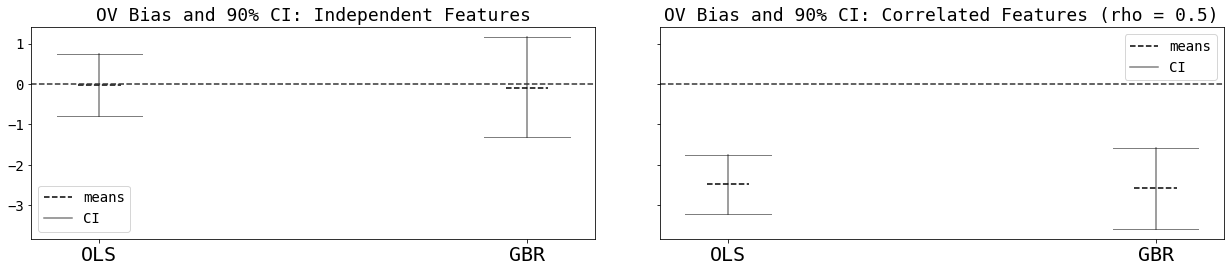

In [44]:
# calculate means and 90% CI
bounds_nocorr = create_means_bounds_mc(df = bias_nocorr, qmin = 0.05, qmax = 0.95)
bounds_corr = create_means_bounds_mc(df = bias_corr, qmin = 0.05, qmax = 0.95)
# plot results
fig, ax = plt.subplots(1,2, figsize = (18,4), sharey = True)
dict_bounds = {0 : bounds_nocorr, 1 : bounds_corr}
dict_title =  {0 : 'Independent Features', 1 : 'Correlated Features (rho = 0.5)'}
for i in range(2):
    ax_i = ax[i]
    params_i = dict_bounds[i][['ols_bias', 'gb_bias']]  # I only need the bias columns
    params_i = params_i.rename(columns = {'ols_bias': 'OLS', 'gb_bias': 'GBR'}) # rename for readability
    means_i = params_i.loc['mean']
    ind_ptile = [ind for ind in params_i.index if ind.find('percentile') >= 0]
    bounds_i = params_i.loc[ind_ptile].values
    var_labels = params_i.columns
    true_included = [val for a,val in enumerate(alpha) if vars_to_exclude[a] == False]
    # plot
    ax_i = plot_conf_intervals(means=means_i, bounds=bounds_i, var_labels=var_labels, ax=ax_i,
                                plot_bars=False)
    title = ax_i.set_title(f'OV Bias and 90% CI: {dict_title[i]}', fontsize = 18)
    labs_i = ax_i.get_xticklabels()
    ax_i.set_xticklabels(labs_i, fontsize = 20)
    #ax_i.axis([-0.5,1.5,-1,4])

## 6. Outliers: let's check what happens when we have outliers

* **Strategy**: instead of drawing normal residuals, let's have Gamma distributed residuals
* **First**: visualize a Gamma distribution to get a sense of what I'm doing (understand role of scale and shape pars)
* **Second**: Train OLS a GB regression _without_ outlier-handling
* **Try other things**: dropping outliers, log transformation, etc


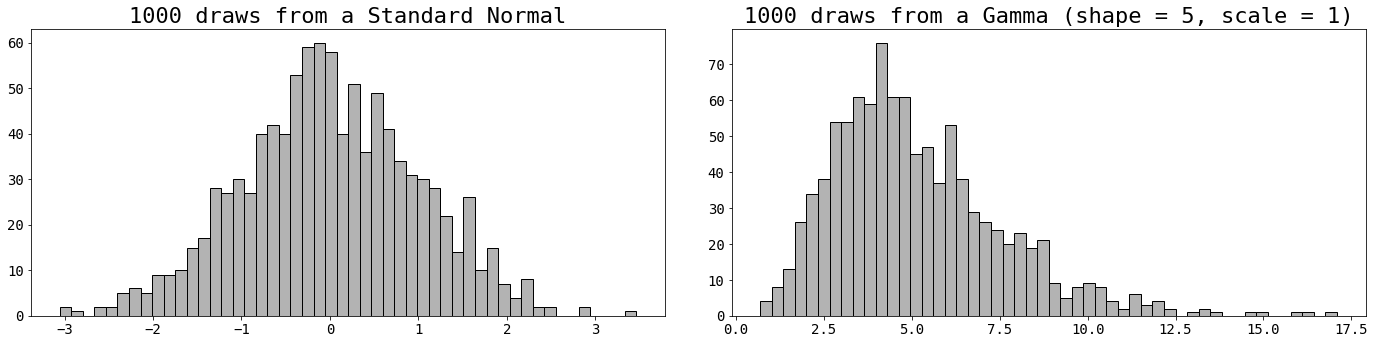

In [45]:
# first, visualize the distributions
nobs = 1000
np.random.seed(4122)
# Draw from normal distribution
df_draws = pd.DataFrame(index = range(nobs), columns = ['normal', 'gamma'])
df_draws['normal'] = np.random.randn(nobs)
# Draw from Gamma distribution with shape and scale parameters
shape = 5
scale = 1
df_draws['gamma'] = np.random.gamma(shape = shape, scale=scale, size=nobs)
# plot
fig, ax = plt.subplots(1,2, figsize=(20,5))
dict_title = {0:'Standard Normal', 1:f'Gamma (shape = {int(shape)}, scale = {int(scale)})'}
# deciles are just cluttering my plot: make it optional
plot_deciles = False
for c, col in enumerate(df_draws.columns):
    hist_c = ax[c].hist(df_draws[col], bins = 50, edgecolor = 'k', facecolor='0.7')
    ax[c].set_title(f'{nobs} draws from a {dict_title[c]}', fontsize = 22)
    # plot deciles
    deciles = df_draws[col].quantile(np.linspace(0,1,11))
    ymin, ymax = ax[c].get_ylim()
    if plot_deciles:
        for d,dec in enumerate(deciles.index):
            x_d = deciles.loc[dec]
            ax[c].plot([x_d, x_d], [ymin, ymax], ls = 'dotted', alpha = 0.5, color = 'k')
            if d == len(deciles.index)-1:
                ax[c].legend(['deciles'])
    ax[c].set_ylim([ymin, ymax])

In [46]:
def plot_gaussian_kde(data, ax, drop_outliers = False, pmin = 0, pmax = 0.95, cov_factor = None,
                      plot_kde = True, **kwargs):
    """
    Make a plot of a gaussian Kernel Density Estimate of the distribution of some data
    Inputs:
        data: series or array with data 
        ax: axis object to store the plot
        drop_outliers: Boolean: if True: outliers will be dropped with user-provided quantiles
        pmin, pmax: floats between 0 and 1: bottom and top percentiles accepted
        cov_factor: if not None, user can set the bandwidth otherwise is default
    """
    color = 'k'
    ls = '-'
    alpha = 0.5
    label = ''
    if kwargs:
        color = kwargs['color']
        ls = kwargs['ls']
        alpha = kwargs['alpha']
        label = kwargs['label']
    # drop NaNs if any and drop outliers
    data = np.array(data[np.isnan(data)==False]).flatten()
    if drop_outliers:
        qmin, qmax = np.percentile(data, [100*pmin, 100*pmax])
        bool_keep = np.logical_and(data >= qmin, data <= qmax)
        data = data[bool_keep]
    # Gaussian KDE
    density = gaussian_kde(data)
    grid_size = 50
    gridx = np.linspace(np.min(data),np.max(data),grid_size).flatten()
    if cov_factor is not None:
        density.covariance_factor = lambda : cov_factor
        density._compute_covariance()
    # evaluate KDE on grid    
    kde = density(gridx)
    if plot_kde:
        ax.plot(gridx, kde, color=color, ls=ls, alpha=alpha, label=label)
    
    return ax ,kde, gridx

In [47]:
def rescale_axis(data1, data2):
    """
    Rescale data1 to data2's scale:
    If data1 ~ [a,b] and data2 ~ [c,d]
    then to rescale: rescaled(data1) = c + (d-c)*(data1-a)/(b-a)
    Inputs:
        data1, data2: arrays of two sets of data
    Returns:
        rescaled data1 to data2's scale (same shape as data1)
    """
    min1, max1 = np.min(data1), np.max(data1)
    min2, max2 = np.min(data2), np.max(data2)
    rescaled_y = min2 + (max2 - min2)*(data1 - min1)/(max1 - min1)
    return rescaled_y

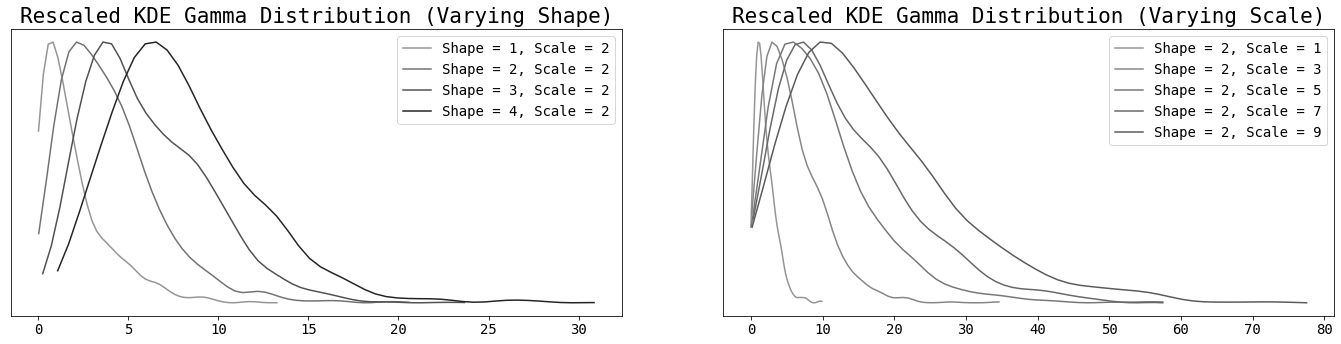

In [48]:
# simulate different draws to get a sense of the impact of the distribution
fig, ax = plt.subplots(1,2, figsize = (20,5))
# Different shape parameters
scale = 2
s_max = 5
shape_grid = range(1,s_max)
color = cm.Greys(np.linspace(0.5, 1, s_max))
nobs = 1000
for s,shp in enumerate(shape_grid):
    shape_s = shape_grid[s]
    lab_s = f'Shape = {shape_s}, Scale = {scale}'
    simu_s = np.random.gamma(shape = shape_s, scale=scale, size=nobs) 
    ax, kde_s, grid_s = plot_gaussian_kde(data = simu_s,
                      ax = ax,
                      cov_factor = None,
                      drop_outliers = False,
                      plot_kde = False)
    if s == 0:  # rescale using the first simulation as referencxe
        init_data = kde_s.copy()
    data_s = rescale_axis(kde_s, init_data)
    ax[0].plot(grid_s, data_s, color = color[s], ls = '-', label=lab_s)
ax[0].legend(loc=1)
ax[0].set_title('Rescaled KDE Gamma Distribution (Varying Shape)', fontsize = 21)
yts = ax[0].set_yticks([])  # drop ticks and labels: drop distractions that can create confusion
ytl = ax[0].set_yticklabels([])
# Different scale parameters
shape = 2
s_max = 10
scale_grid = range(1,s_max,2)
color = cm.Greys(np.linspace(0.5, 1, s_max))
nobs = 1000
for s,scl in enumerate(scale_grid):
    lab_s = f'Shape = {shape}, Scale = {scl}'
    simu_s = np.random.gamma(shape=shape, scale=scl, size=nobs) 
    ax, kde_s, grid_s = plot_gaussian_kde(data = simu_s,
                      ax = ax,
                      cov_factor = None,
                      drop_outliers = False,
                      plot_kde = False)
    if s == 0:  # rescale using the first simulation as referencxe
        init_data = kde_s.copy()
    data_s = rescale_axis(kde_s, init_data)
    ax[1].plot(grid_s, data_s, color = color[s], ls = '-', label=lab_s)
ax[1].legend(loc=1)
ax[1].set_title('Rescaled KDE Gamma Distribution (Varying Scale)', fontsize = 21)
yts = ax[1].set_yticks([])  # drop ticks and labels: drop distractions that can create confusion
ytl = ax[1].set_yticklabels([])

In [49]:
def simulate_gamma_linear_model(alpha, vcv_x, shape, scale, seed, nobs, demean_resids=False):
    """
    Simulate linear model with Gamma residuals 
    Inputs:
        alpha: array with K user-provided coefficients (includes intercept)
        vcv_x: array of dimension (K-1)x (K-1) covariance matrix for X.  Must be positive definite
        seed: random seed
        nobs: number of observations in the sample
        shape, scale: parameters to control the Gamma draws
        demean_resids: Bool: If True resids will be mean zero
    output: y,X dataframes
    """
    np.random.seed(seed)
    K = len(alpha)
    alpha = np.array(alpha).reshape((K,1))   # make it a column vector
    # simulate K-1 normal random: all mean zero (means go to the intercept so it doesn't matter)
    mu = np.array([0]*(K-1)).reshape((K-1,1))
    prex = np.random.multivariate_normal(mean=mu.flatten(), cov=vcv_x, size=nobs)
    ones = np.array([1]*nobs).reshape((nobs,1))  
    X = np.concatenate((ones, prex), axis=1) # include first the column for the intercept
    col_labels = [f'x{num}' for num in range(K)]
    xdf = pd.DataFrame(X, columns = col_labels)
    # Noise is ~Gamma(shape, scale)
    epsilon = np.random.gamma(shape = shape, scale=scale, size=(nobs,1))
    if demean_resids:
        epsilon -= np.mean(epsilon) # to make them mean zero
    y = np.dot(X, alpha) + epsilon
    ydf = pd.DataFrame(y, columns = ['y'])
    return ydf, xdf


In [50]:
# Test: same as with linear
alpha = [1, 0, 0]
var_x = [3,10]
vcv_x = np.diag(var_x)
seed = 42519
nobs = 100
shape = 10
scale = 0
ydf, Xdf = simulate_gamma_linear_model(alpha=alpha, 
                                       vcv_x=vcv_x, 
                                       seed=seed, 
                                       nobs=nobs, 
                                       shape=shape,
                                       scale=scale)
assert (ydf.values==1).all()

In [51]:
def run_montecarlo_gamma(alpha, vcv_x, shape, scale, nobs, num_montecarlo, seed_mc, demean_resids,
                          vars_to_exclude = None):
    """
    Run a Montecarlo simulation with a linear model but Gamma distributed residuals
    Inputs:
        alpha: array with K user-provided coefficients (includes intercept)
        vcv_x: array of dimension (K-1)x (K-1) covariance matrix for X.  Must be positive definite
        shape: Gamma shape parameter
        scale: Gamma shape parameters
        nobs: number of observations in the sample
        num_montecarlo: number of montecarlo samples
        seed_mc: seed for the seeds of each simulation
        vars_to_exclude: Numpy array of booleans (must be same size as alpha)
            True: exclude that variable, False: include it
            used to simulate omitted variables bias
    output: df_alpha: dataframe with the estimted coefficients (size= num_montecarlo x K)
    """
    # check if excluding variables or not and shapes
    if vars_to_exclude is not None:
        vars_to_exclude = np.array(vars_to_exclude)
        if len(vars_to_exclude) != len(alpha):
            raise ValueError("Vars_to_exclude must have the same dimension as alpha")
    else:
        vars_to_exclude = np.array([False]*len(alpha))
    np.random.seed(seed_mc) # seed for generating a random seed: needed to get different samples
    seed_arr = np.random.randint(low=1, high=10000, size=num_montecarlo, dtype=int)
    K = len(alpha)
    col_labels = [f'x{num}' for num in range(K) if vars_to_exclude[num]==False]
    df_alpha = pd.DataFrame(index = range(num_montecarlo), columns = col_labels)  # initialize df
    for i in range(num_montecarlo):
        ydf, Xdf = simulate_gamma_linear_model(alpha=alpha, 
                                       vcv_x=vcv_x, 
                                       seed=seed_arr[i], 
                                       nobs=nobs, 
                                       shape=shape,
                                       scale=scale,
                                       demean_resids=demean_resids)
        Xdf = Xdf[Xdf.columns[vars_to_exclude==False]]
        reg = LinearRegression(fit_intercept=False).fit(Xdf, ydf)  # run regression
        alpha_hat = reg.coef_.flatten()
        df_alpha.loc[i] = alpha_hat
    # convert to float:
    for c, col in enumerate(df_alpha.columns):
        df_alpha[col] = df_alpha[col].astype('float')
        
    return df_alpha

## Let's show that residuals outliers are no problem

* In a linear model a fat tail distribution for the residuals is absorbed by the intercept
* We will have a biased estimate for the intercept, but we don't really care about that

**Next cell runs two simulations**:
1. Gamma distributed residuals that are not mean zero
2. Demeaned Gamma distribuited residuals: once we demean the bias is lost again

Also, I'm showing parametric Confidence Intervals as opposed to the non parametric used before:
* `Parametric`: assume a distribution (in this case Normal), so 95% CI are computed as $$mean + 1.96 \times std.err$$
* `Non parametric`: no distributional assumption is made, I just compute the corresponding quantiles and take these as the lower and upper limit

In [52]:
alpha = [2, 3.5, -5]
vcv_x = np.diag([3,10])
seed = 52519
nobs = 100
shape = 1
scale = 9
sze_montecarlo = 300
# Simulated residuals are not transformed
gamma_mc = run_montecarlo_gamma(alpha=alpha, vcv_x=vcv_x, shape=shape, scale=scale, 
                            nobs=nobs, num_montecarlo=sze_montecarlo, seed_mc=seed_mc, demean_resids=False)
# Simulated residuals are demeaned
gamma_mc_dem = run_montecarlo_gamma(alpha=alpha, vcv_x=vcv_x, shape=shape, scale=scale, 
                            nobs=nobs, num_montecarlo=sze_montecarlo, seed_mc=seed_mc, demean_resids=True)

Text(0.5, -0.08, 'Bias (truncated) =  -9.1')

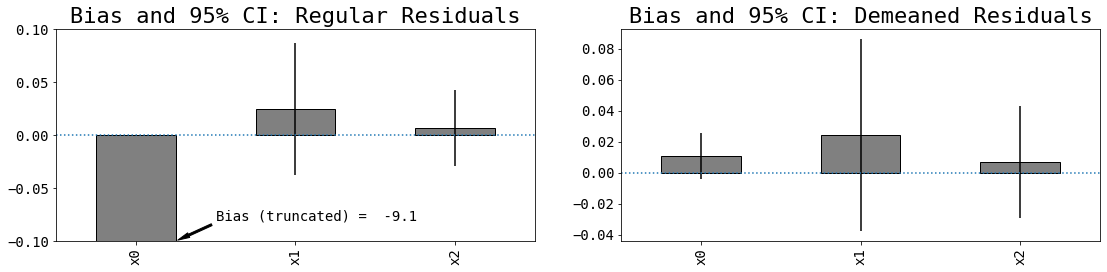

In [53]:
# bias terms: true - E(estimate)
bias_mc = alpha - gamma_mc.mean()
bias_mc_dem = alpha - gamma_mc_dem.mean()
# I want to easily plot CI around estimates:
# Compute CI = mean +- 2*(standard error of the mean)
# Note!  This is a parametric CI (I assume normality)
# For a non-parametric I'd just use the quantiles
len_ci_mc = 1.96*(alpha - gamma_mc).sem()
len_ci_mc_dem = 1.96*(alpha - gamma_mc_dem).sem()
# plot
fig, ax = plt.subplots(1,2, figsize = (16,4))
bias_mc.plot(kind='bar', yerr = len_ci_mc, color = '0.5', edgecolor='k', ax = ax[0])
bias_mc_dem.plot(kind='bar', yerr = len_ci_mc_dem, color = '0.5', edgecolor='k', ax = ax[1])
dict_titl = {0:'Bias and 95% CI: Regular Residuals', 1:'Bias and 95% CI: Demeaned Residuals'}
for i in range(2):
    mini, maxi = ax[i].get_xlim()
    ax[i].plot([mini, maxi], [0,0], ls = 'dotted')
    ax[i].set_title(dict_titl[i])
ax[0].set_ylim([-0.1,0.1])
real_val = np.around(bias_mc.loc['x0'], decimals=1)
ax[0].annotate(f'Bias (truncated) =  {real_val}', xy=(0.25, -0.1), xytext=(0.5, -0.08),
            arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth = 5))

### Now let's simulate outliers on one of the features: `x2`

* I'll do this by drawing `x2` from a Gamma distribution

In [54]:
def simulate_linear_model_gammafeat(alpha, vcv_x, var_epsilon, shape, scale, seed, nobs):
    """
    Simulate linear model with Normal residuals and last of the features Gamma(scale, shape)
    Inputs:
        alpha: array with K user-provided coefficients (includes intercept)
        vcv_x: array of dimension (K-1)x (K-1) covariance matrix for X.  Must be positive definite
        var_epsilon: variance for normal errors
        seed: random seed
        nobs: number of observations in the sample
        shape, scale: parameters to control the Gamma draws for last feature
        demean_resids: Bool: If True resids will be mean zero
    output: y,X dataframes
    """
    np.random.seed(seed)
    K = len(alpha)
    alpha = np.array(alpha).reshape((K,1))   # make it a column vector
    # simulate K-1 normal random: all mean zero (means go to the intercept so it doesn't matter)
    mu = np.array([0]*(K-1)).reshape((K-1,1))
    prex = np.random.multivariate_normal(mean=mu.flatten(), cov=vcv_x, size=nobs)
    ones = np.array([1]*nobs).reshape((nobs,1))  
    X = np.concatenate((ones, prex), axis=1) # include first the column for the intercept
    col_labels = [f'x{num}' for num in range(K)]
    xdf = pd.DataFrame(X, columns = col_labels)
    # I'm going to make the change here: replace previous draw with a Gamma(shape,scale)
    xdf[xdf.columns[-1]] = np.random.gamma(shape=shape, scale=scale, size=nobs)
    epsilon = np.sqrt(var_epsilon)*np.random.randn(nobs,1)
    y = np.dot(X, alpha) + epsilon
    ydf = pd.DataFrame(y, columns = ['y'])
    return ydf, xdf


Text(0.5, 1.0, 'KDE Plots for Simulated y, X1 and X2')

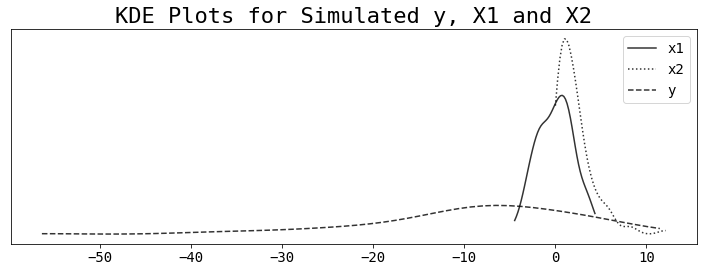

In [55]:
# check that it was done correctly: plot distributions
alpha = [2, 3.5, -5]
vcv_x = np.diag([3,10])
seed = 13601
nobs = 100
shape = 1
scale = 10
scale = 2
var_epsilon = 1
ydf, xdf = simulate_linear_model_gammafeat(alpha, vcv_x, var_epsilon, shape, scale, seed, nobs)
# plot KDEs
fig, ax = plt.subplots()
ls_list = ['-', 'dotted']
for c, col in enumerate(xdf.columns[1:]):
    res_c = plot_gaussian_kde(data = xdf[col].values,
                          ax = ax,
                          cov_factor = None,
                          drop_outliers = False,
                          plot_kde = True,
                          color = 'k', ls = ls_list[c], alpha = 0.8, label=col)
# plot y too    
res_c = plot_gaussian_kde(data = ydf.values,
                      ax = ax,
                      cov_factor = None,
                      drop_outliers = False,
                      plot_kde = True,
                      color = 'k', ls = '--', alpha = 0.8, label='y')
ax.legend()
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_title('KDE Plots for Simulated y, X1 and X2')

#### One common way of to handle outliers is to transform the outcome variable using the natural logarithm

* I will be testing this below
* We need to find a way to translate the coefficients from a loglinear model into a linear model

The linear model with one regressor (logic applies for more features)
$$
y = \alpha_0 + \alpha_1 x_1 + \epsilon
$$

So the coefficient is the marginal effect:
$$
\frac{\partial E(y|x_1)}{\partial x_1} = \alpha_1
$$

In loglinear:
$$
ln(y) = \beta_0 + \beta_1 x_1 + \eta
$$

So the coefficient is the marginal effect:
$$
\frac{\partial E(ln(y)|x_1)}{\partial x_1} = \beta_1
$$

But note that 
$$
\frac{\partial ln(y)}{\partial x} = \frac{\partial y}{\partial x} \frac{1}{y}
$$

So we get that 
$$
\alpha_1 = y \beta_1
$$

Text(0.5, 1.0, 'Comparing Linear and Log Parameters')

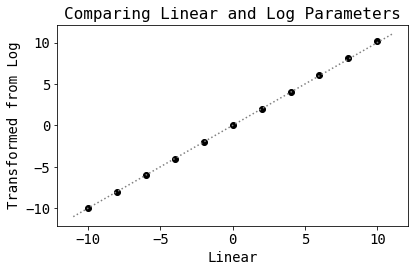

In [56]:
# let's test the derivation above
# I will create some variation in alpha (grid_a1)
# Since y varies, I use AVG(y) to apply the transformation of loglinear --> linear
np.random.seed(10)
nobs = 10
grid_a1 = np.linspace(-10,10,11)
df_log = pd.DataFrame(index = grid_a1, columns = ['linear','log'])
k = 1 # rescaling of the intercept if needed
x = np.sqrt(k)*np.random.randn(nobs,1)
noise = np.sqrt(1)*np.random.randn(nobs)
for a, alph in enumerate(grid_a1):
    # true model
    y = k*100 + alph*x + noise
    # estimate OLS
    reg = LinearRegression().fit(x, y)
    lreg = LinearRegression().fit(x, np.log(y))
    alpha_hat = reg.coef_.flatten()[0]
    log_alpha_hat = lreg.coef_.flatten()[0]
    df_log.loc[alph] = [alpha_hat, log_alpha_hat]
    
# alpha1 = beta1*y (here I multiply by AVG(y))
df_log['log x mean(y)'] = df_log.log*np.mean(y)
fig, ax = plt.subplots(figsize = (6,4))
ax.scatter(df_log.linear, df_log['log x mean(y)'], color ='k')
xmin, xmax = ax.get_xlim()
xgrid = np.linspace(xmin, xmax,5)
ax.plot(xgrid, xgrid, ls='dotted', color='0.5')  # 45 degrees for visual comparison
ax.set_xlabel('Linear', fontsize =14)
ax.set_ylabel('Transformed from Log', fontsize = 14)
ax.set_title('Comparing Linear and Log Parameters', fontsize = 16)

In [57]:
def compute_pdp_slope(xdf, model, drop_outliers, pmin, pmax, prop_factor=1, transform=None):
    """
    Use the PDP of a model to compute the slope for comparison
        with linear regression.  This is done for each MC draw
    xdf: DF with all features used in model training
    model: object storing the results of training
    prop_factor: proportionality factor to translate from log to linear
        alpha = beta*prop_factor (prof_factor = median(y) or AVG(y))
    transform: transformation method in (None, 'log', 'quantile')
    """
    cols = xdf.columns
    df_slope = pd.DataFrame(index = cols, columns = ['slope'])
    for c, col in enumerate(cols):
        df_pdp, _ = create_pdp(xdf=xdf, name_var=col, model=model, 
                               drop_outliers=drop_outliers, pmin=pmin, pmax=pmax,)
        x_pdp = df_pdp.index.values.reshape((len(df_pdp.index),1))
        y_pdp = df_pdp.score.values
        # linear regression to get the slope of the pdp: 
        #    intercept allows for a parallel shift --> what matters is the slope of the pdp
        reg_pdp = LinearRegression(fit_intercept = True).fit(x_pdp, y_pdp)
        slope_pdp = reg_pdp.coef_[0]
        # if transform = log I need to translate this coefficient alpha = beta*y
        if transform == 'log':
            slope_pdp *= prop_factor
        # store everything
        df_slope['slope'][col] = slope_pdp
        
    return df_slope
    

In [58]:
# let's test this
# if model = LinearRegression I should get something similar!
alpha = [2, 3.5, -5]
vcv_x = np.diag([1,1]) # everything is standard normal
var_epsilon = 1
seed = 14613
nobs = 100
# simulate model
ydf_test, Xdf_test = simulate_normal_linear_model(alpha=alpha, 
                                   vcv_x=vcv_x, 
                                   var_epsilon=var_epsilon,
                                   seed=seed, 
                                   nobs=nobs)
# model is OLS: from here I can compute the slope of the pdp
test_mod = LinearRegression(fit_intercept=False).fit(Xdf_test, ydf_test)  # run regression
test_pdp_slope = compute_pdp_slope(xdf=Xdf_test, 
                                   model=test_mod, 
                                   drop_outliers=False, pmin=0, pmax=1)
test_pdp_slope['true'] = alpha
test_pdp_slope


,slope,true
x0,0,2.0
x1,3.52756,3.5
x2,-4.88211,-5.0


Text(0.5, 0, 'Max Depth')

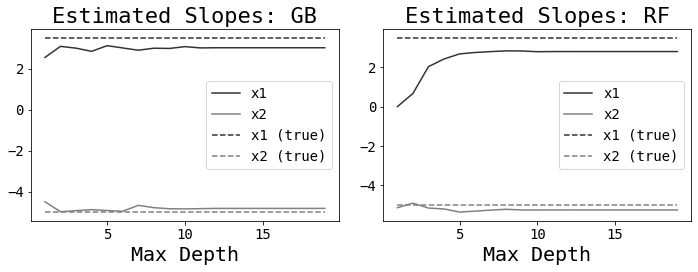

In [59]:
# Continue with testing and understanding of `compute_pdp_slope`
max_depth = 20
grd_depth = range(1,max_depth)
df_slope_rf = pd.DataFrame(index=grd_depth, columns = ['x1','x2'])
df_slope_gb = pd.DataFrame(index=grd_depth, columns = ['x1','x2'])
for d, depth in enumerate(grd_depth):
    # fit models 
    rf_d = RandomForestRegressor(max_depth=depth, random_state=0).fit(Xdf_test, ydf_test.values.flatten())
    gb_d = GradientBoostingRegressor(max_depth=depth, random_state=0).fit(Xdf_test, ydf_test.values.flatten())
    # compute slopes
    tail_delta = 0.1 # how much to trim for outlier detection
    slope_rf_d = compute_pdp_slope(xdf=Xdf_test, model=rf_d, 
                                   drop_outliers=True, pmin=0+tail_delta, pmax=1-tail_delta)
    slope_gb_d = compute_pdp_slope(xdf=Xdf_test, model=gb_d, 
                                   drop_outliers=True, pmin=0+tail_delta, pmax=1-tail_delta)
    # store
    df_slope_rf.loc[depth] = slope_rf_d.loc[['x1','x2']].values.flatten()
    df_slope_gb.loc[depth] = slope_gb_d.loc[['x1','x2']].values.flatten()
    
true_df = pd.DataFrame(np.tile(np.array(alpha[1:]),(len(grd_depth),1)), index=grd_depth, 
                       columns = ['x1 (true)','x2 (true)'])
# plot results
fig, ax = plt.subplots(1,2)
# GB
color = ['0.2', '0.5']
gb=df_slope_gb.plot(ax=ax[0], color=color)
tr = true_df.plot(ax=ax[0], color=color, ls='--', legend=True)
ax[0].set_title('Estimated Slopes: GB')
# RF
rf=df_slope_rf.plot(ax=ax[1], color=color)
tr = true_df.plot(ax=ax[1], color=color, ls='--', legend=True)
ax[1].set_title('Estimated Slopes: RF')
ax[1].set_xlabel('Max Depth')
ax[0].set_xlabel('Max Depth')


In [60]:
def run_montecarlo_gamma_feat(alpha, vcv_x, var_epsilon, shape, scale, nobs, 
                              num_montecarlo, seed_mc, max_depth, transform = None,
                              drop_outliers = False,
                              pmin=0, pmax=1):
    """
    Run a Montecarlo simulation with a linear model but Gamma distributed residuals.
        Train OLS, Gradient Boosting and RF for comparison
    Inputs:
        alpha: array with K user-provided coefficients (includes intercept)
        vcv_x: array of dimension (K-1)x (K-1) covariance matrix for X.  Must be positive definite
        var_epsilon: residual variance for Normal distributions
        shape, scale: Gamma shape parameter for last feature
        nobs: number of observations in the sample
        num_montecarlo: number of montecarlo samples
        seed_mc: seed for the seeds of each simulation
        max_depth: Maximum Depth for Gradient Boosting Regression
        transform: [None, 'log'] If 'log': apply log transformation to Y
        drop_outliers: Boolean to drop outliers determined by percentiles pmin, pmax
        pmin, pmax = pecentiles to drop outliers (default: no dropping)
    Outputs: 
        df_ols: dataframe with the estimted coefficients from OLS (size= num_montecarlo x K)
        df_gb: dataframe with the estimted coefficients from Gradient Boosting Reg (size= num_montecarlo x K)
    """
    np.random.seed(seed_mc) # seed for generating a random seed: needed to get different samples
    seed_arr = np.random.randint(low=1, high=10000, size=num_montecarlo, dtype=int)
    K = len(alpha)
    col_labels = [f'x{num}' for num in range(K)]
    # initialize DFs to store results
    df_ols = pd.DataFrame(index = range(num_montecarlo), columns = col_labels)
    df_gb = pd.DataFrame(index = range(num_montecarlo), columns = col_labels)
    df_rf = pd.DataFrame(index = range(num_montecarlo), columns = col_labels)
    median_y = pd.DataFrame(index = range(num_montecarlo), columns = ['median_y'])
    for i in range(num_montecarlo):
        ydf, Xdf = simulate_linear_model_gammafeat(alpha=alpha, 
                                       vcv_x=vcv_x, 
                                       var_epsilon=var_epsilon,
                                       seed=seed_arr[i], 
                                       nobs=nobs, 
                                       shape=shape,
                                       scale=scale)
        # Transform: if user passes transformation method
        prop_factor = ydf.y.median()  # this is needed to transform from log to linear
        if transform == 'log':
            pos_trans = ydf.y.min() - np.finfo(np.float32).eps  # translation to get positive values
            ydf = np.log(ydf - pos_trans)
        if drop_outliers:
            qmin, qmax = ydf['y'].quantile([pmin,pmax]).values
            bool_included = np.logical_and(ydf >= qmin, ydf <= qmax).values.flatten()
            ix_included = ydf.index[bool_included] # find included indexes 
            ydf = ydf.loc[ix_included]
            Xdf = Xdf.loc[ix_included]
        # Train models
        # 1. OLS
        reg = LinearRegression(fit_intercept=False).fit(Xdf, ydf)  # run regression
        alpha_hat = reg.coef_.flatten()
        df_ols.loc[i] = alpha_hat
        # 2 run GB and estimate slope coeficient
        modgb = GradientBoostingRegressor(random_state=1089, max_depth = max_depth)
        modgb.fit(Xdf, ydf.values.flatten())
        df_pre_gb = compute_pdp_slope(xdf=Xdf, model=modgb, prop_factor=prop_factor,
                                     transform=transform, 
                                     drop_outliers=drop_outliers, 
                                     pmin=pmin, pmax=pmax)
        df_gb.loc[i] = df_pre_gb.slope.values
        # 3 Repeat for Random Forest
        modrf = RandomForestRegressor(random_state=1089, max_depth = max_depth)
        modrf.fit(Xdf, ydf.values.flatten())
        df_pre_rf = compute_pdp_slope(xdf=Xdf, model=modrf, prop_factor=prop_factor,
                                     transform=transform, 
                                     drop_outliers=drop_outliers, 
                                     pmin=pmin, pmax=pmax)
        df_rf.loc[i] = df_pre_rf.slope.values
        
        # I want to save the medians
        median_y.loc[i] = prop_factor

    # convert to float:
    for c, col in enumerate(df_gb.columns):
        df_ols[col] = df_ols[col].astype('float')
        df_gb[col] = df_gb[col].astype('float')
        df_rf[col] = df_rf[col].astype('float')
    # save results in a dictionary
    dict_results = {'ols' : df_ols, 'gb' : df_gb, 'rf' : df_rf, 'median_y' : median_y}   
    
    return dict_results

In [61]:
def create_bounds_ci(df, cols, pmin, pmax, nonparametric=True):
    """
    Helper function to create bounds for CI calculation
    Inputs:
        df: DataFrame: has the data for which we want to create bounds
        cols: list of strings: columns in df
        pmin, pmax: bounds to compute the CI of size pmax-pmin (default: 10% CI)
        nonparametric: Boolean: if True nonparametric bounds 
    Outputs:
        mean: array with mean
        bounds: array with bounds
    """
    df_cols = df[cols]
    mean = df_cols.mean()
    if nonparametric:
        bounds = df_cols.quantile([pmin,pmax]).values
    else:
        sem = df_cols.std()
        crit_val = ((pmax-pmin)+1)/2  # to make parametric and non-parametric comparable
        bound_l, bound_h = mean - norm.ppf(crit_val)*sem, mean + norm.ppf(crit_val)*sem
        bounds = np.array([bound_l.values, bound_h.values])
    return mean, bounds

Text(0.5, 0, 'Sample Size for Each Draw')

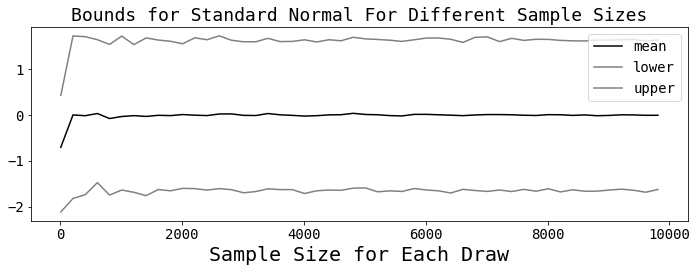

In [62]:
# let's test with a standard Normal distribution, 90% CI
# Mean = 0, 
# Bounds = +\- 1.645
np.random.seed(6301)
grd_size = range(10,int(10e3),200)
df_test = pd.DataFrame(index=grd_size, columns=['mean', 'lower', 'upper'])
for i,sze in enumerate(grd_size):
    df_norm_i = pd.DataFrame(np.random.randn(sze), columns = ['std_normal'])
    mean_i, bounds_i = create_bounds_ci(df=df_norm_i, cols=df_norm_i.columns, 
                                        pmin=0.05, pmax=0.95, nonparametric=True)
    df_test.loc[sze] = [mean_i.values[0]] + list(bounds_i.flatten())
# plot results
fig, ax = plt.subplots()
df_test.plot(color=['k', '0.5', '0.5'], ax=ax)
ax.set_title('Bounds for Standard Normal For Different Sample Sizes', fontsize=18)
ax.set_xlabel('Sample Size for Each Draw')

In [63]:
def plot_bias_mc(dict_results, cols, ax, true_params, pmin=0.05, pmax=0.95, nonparametric=True):
    """
    Plot bias from mc_gamma_feat: allow for parametric and non-parametric CI
        parametric: use Normal distribution
        non-parametric: use the quantiles corresponding to pmin, pmax
    Inputs:
        dict_results: dictionary from run_montecarlo_gamma_feat (ols, gb)
        cols: list of columns we want to compute and plot bias and CI
        ax: axis object
        true_params: array with true parameters
        pmin, pmax: bounds to compute the CI of size pmax-pmin (default: 10% CI)
        nonparametric: Boolean: if True nonparametric bounds 
    """
    methods = [meth for meth in dict_results.keys() if meth != 'median_y']
    ci_length = int(100*np.around(pmax-pmin, decimals=2))
    dict_mb = {}
    titl_pre = 'Non-Param.'
    if nonparametric==False:
        titl_pre = 'Parametric'
    for m, meth in enumerate(methods):
        if len(methods)>1:
            ax_m = ax[m]
        else:
            ax_m = ax
        res_df = dict_results[meth]
        bias = res_df - true_params
        mean, bounds = create_bounds_ci(df=bias, cols=cols, pmin=pmin, pmax=pmax, 
                                        nonparametric=nonparametric)
        n_plots = len(mean)
        # plot bars and error lines by hand
        grid_x = range(n_plots)
        ax_m.bar(grid_x, mean, edgecolor='k', facecolor='0.5')
        for i in grid_x:
            ax_m.plot([i,i], [bounds[0,i],bounds[1,i]], color = 'k')
        xmin, xmax = ax_m.get_xlim()
        ymin, ymax = ax_m.get_ylim()
        hline = ax_m.plot([xmin, xmax], [0,0], ls = 'dotted', color ='k')
        title = ax_m.set_title(f'{titl_pre} Bias and {ci_length}% CI ({meth})')
        ax_m.set_xticks(grid_x)    
        ax_m.set_xticklabels(cols, rotation=0, fontsize=16)
        dict_mb[meth] = mean, bounds
    return ax, dict_mb

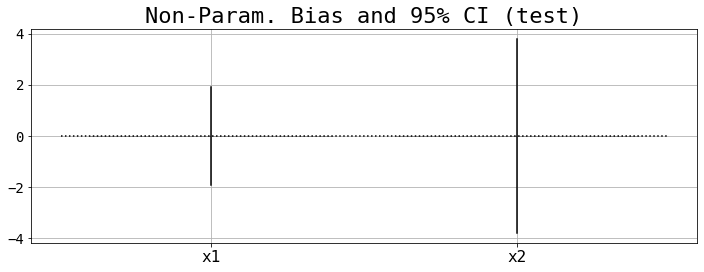

In [64]:
# test it with something I know: two mean zero arrays where arr2 = 2*arr1
dict_test = {}
mean_test = 1
arr_test = mean_test + np.array([[-2,-1,0,1,2],[-4,-2,0,2,4]]).T
df_test = pd.DataFrame(arr_test, columns = ['x1', 'x2'])
dict_test['test'] = df_test
fig, ax = plt.subplots()
k = 0.025
cols = ['x1','x2']
ax_t, df_mb_t = plot_bias_mc(dict_results=dict_test, 
             cols=cols, ax=ax, true_params = [mean_test]*2, pmin=0.0+k, pmax=1-k, nonparametric=True)
ax_t.grid(True)

In [65]:
alpha = [2, 3.5, -5]
vcv_x = np.diag([3,10])
seed = 11469
nobs = 100
shape = 1
scale = 2
var_epsilon = 1
sze_montecarlo = 300
max_depth = 10  # since RF is quite sensitive to this parameter I'm making it large enough
# No transformation applied
dict_mc_feat = run_montecarlo_gamma_feat(alpha=alpha, var_epsilon=var_epsilon,
                            vcv_x=vcv_x, shape=shape, scale=scale, max_depth=max_depth,
                            nobs=nobs, num_montecarlo=sze_montecarlo, seed_mc=seed_mc)


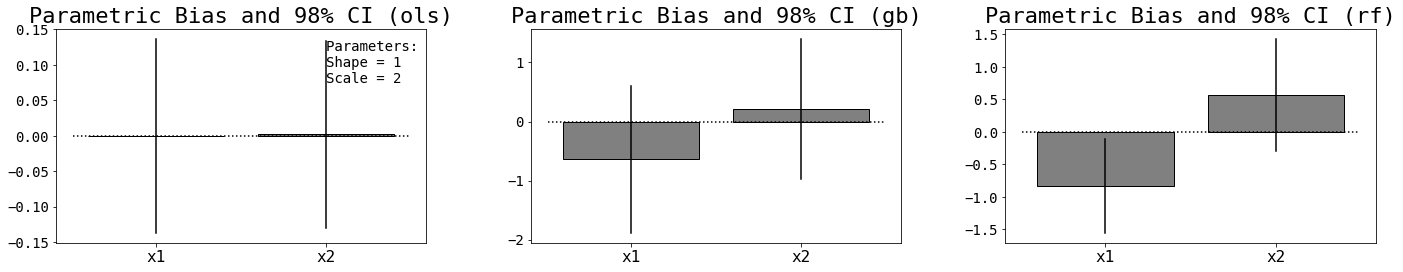

In [66]:
# parametric bias
fig, ax = plt.subplots(1, 3, figsize = (20,4))
ax, dict_mb = plot_bias_mc(dict_results = dict_mc_feat, cols = ['x1','x2'], ax=ax, true_params=alpha, 
                 nonparametric=False, pmin=0.01, pmax=0.99)
ymin, ymax = ax[0].get_ylim()
txt = ax[0].text(1,0.9*ymax, f'Parameters: \nShape = {shape} \nScale = {scale}', verticalalignment='top')

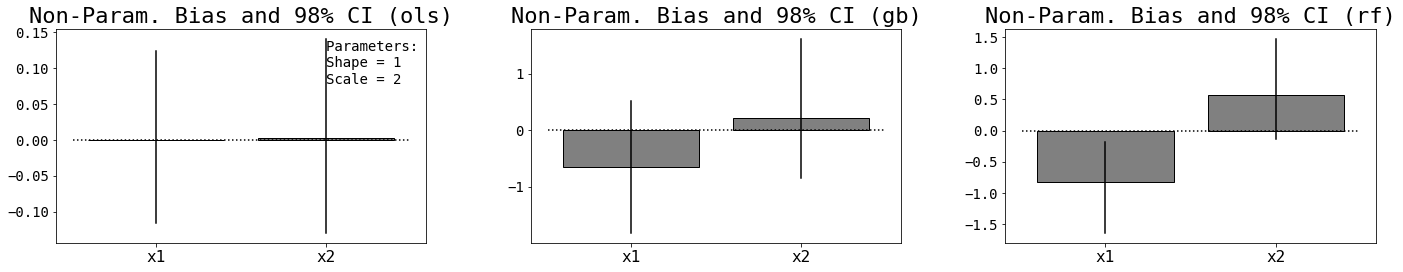

In [67]:
# non-parametric bias
fig, ax = plt.subplots(1, 3, figsize = (20,4))
ax, dict_mb = plot_bias_mc(dict_results = dict_mc_feat, cols = ['x1','x2'], ax=ax, true_params=alpha, 
                 nonparametric=True, pmin=0.01, pmax=0.99)
ymin, ymax = ax[0].get_ylim()
txt = ax[0].text(1,0.9*ymax, f'Parameters: \nShape = {shape} \nScale = {scale}', verticalalignment='top')

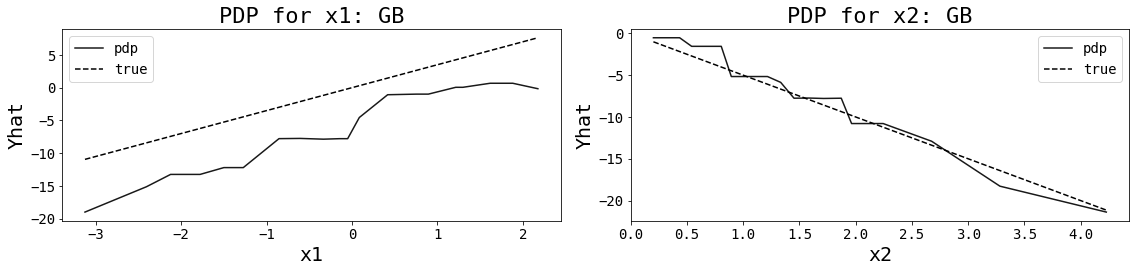

In [68]:
# let's inspect what's going on with GB regression
# Slopes look good (and that's all that matters)
seed_gb = np.random.seed(9711)
ydf, Xdf = simulate_linear_model_gammafeat(alpha=alpha, 
                               vcv_x=vcv_x, 
                               var_epsilon=var_epsilon,
                               seed=seed_gb, 
                               nobs=nobs, 
                               shape=shape,
                               scale=scale)
mod = GradientBoostingRegressor(random_state=1089, max_depth = max_depth)
mod.fit(Xdf, ydf.values.flatten())
fig, ax = plt.subplots(1,2, figsize = (16,4))
for c, col in enumerate(Xdf.columns[1:]):
    # pdp
    ax[c], y_c, _ = plot_pdp(Xdf, col, mod, ax[c], ydf_string = 'Score', drop_outliers = True, 
                            pmin=0.1, pmax=0.9)   
    # true
    true_c = alpha[c+1]*y_c.index
    ax[c].plot(y_c.index, true_c, ls='--', color = 'k')
    ax[c].legend(['pdp', 'true'])
    titl_c = ax[c].get_title()
    titl_c = ax[c].set_title(f'{titl_c}: GB')    

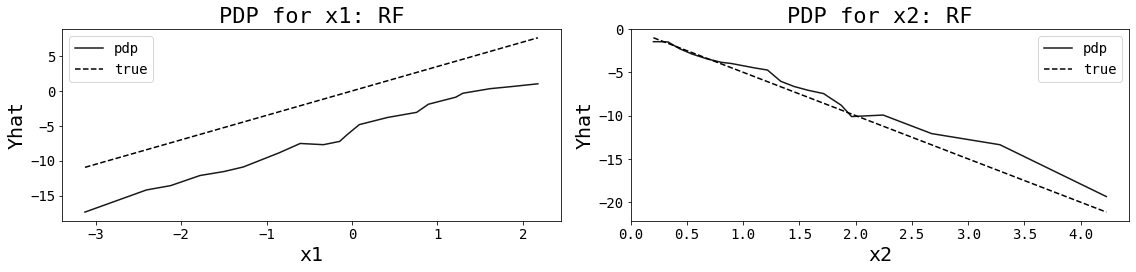

In [69]:
# Now RF
mod = RandomForestRegressor(random_state=1089, max_depth = 10)  # <-- note that I adjusted the max depth
mod.fit(Xdf, ydf.values.flatten())
fig, ax = plt.subplots(1,2, figsize = (16,4))
for c, col in enumerate(Xdf.columns[1:]):
    # pdp
    ax[c], y_c, _ = plot_pdp(Xdf, col, mod, ax[c], ydf_string = 'Score', drop_outliers = True, pmin=0.1, pmax=0.9,
                            ls='-')   
    # true
    true_c = alpha[c+1]*y_c.index
    ax[c].plot(y_c.index, true_c, ls='--', color = 'k')
    ax[c].legend(['pdp', 'true'])
    titl_c = ax[c].get_title()
    titl_c = ax[c].set_title(f'{titl_c}: RF')

### We can now test dropping outliers and log transformation

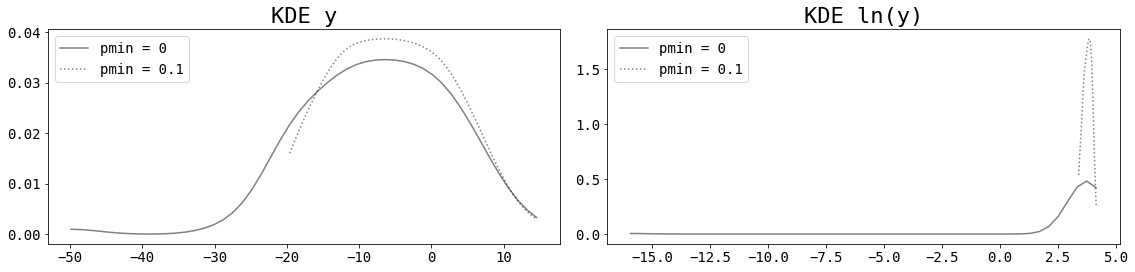

In [70]:
# let's see what the log transformation is doing with and without dropping outliers
fig, ax = plt.subplots(1,2, figsize = (16,4))
logy = np.log(ydf.y - ydf.y.min() + np.finfo(np.float32).eps)
dict_y = {0 : ydf.y, 1 : logy}
dict_ttl = {0 : 'KDE y', 1 : 'KDE ln(y)'}
for i in range(2):
    for pmin in [0,0.1]:
        ls = '-'
        if pmin > 0:
            ls = 'dotted'
        ax[i],_,_ = plot_gaussian_kde(data = dict_y[i], ax=ax[i], drop_outliers = True, pmin = pmin, pmax = 1, 
                                      cov_factor = None,
                              plot_kde = True, color='k', ls=ls, alpha=0.5, label=f'pmin = {pmin}')
    ax[i].set_title(dict_ttl[i])
    ax[i].legend()

In [71]:
# repeat with log transform and quantile transform
alpha = [2, 3.5, -5]
vcv_x = np.diag([3,10])
seed = 11469
nobs = 100
shape = 1
scale = 2
var_epsilon = 1
sze_montecarlo = 300
max_depth = 3
# Log transformation without dropping outliers
dict_mc_feat_log = run_montecarlo_gamma_feat(alpha=alpha, var_epsilon=var_epsilon,
                            vcv_x=vcv_x, shape=shape, scale=scale, max_depth=max_depth,
                            nobs=nobs, num_montecarlo=sze_montecarlo, seed_mc=seed_mc, transform = 'log')
# Outlier dropping with percentiles
dict_mc_feat_qtle = run_montecarlo_gamma_feat(alpha=alpha, var_epsilon=var_epsilon,
                            vcv_x=vcv_x, shape=shape, scale=scale, max_depth=max_depth,
                            nobs=nobs, num_montecarlo=sze_montecarlo, seed_mc=seed_mc, 
                            transform = None, drop_outliers = True, pmin=0.2, pmax=1)

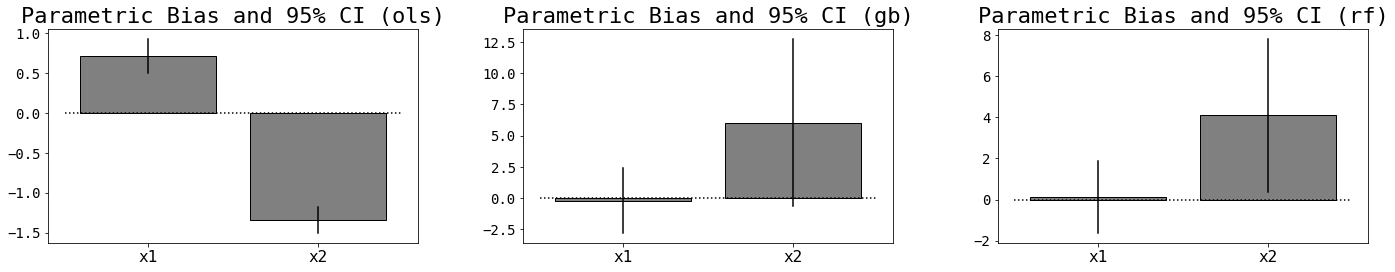

In [72]:
# Logarithmic transformation
fig, ax = plt.subplots(1, 3, figsize = (20,4))
# Convert true parameters alpha --> beta
true_beta = np.array(alpha)/dict_mc_feat_log['median_y'].median_y.median()
ax, d_bm = plot_bias_mc(dict_results = dict_mc_feat_log, cols = ['x1','x2'], ax=ax, true_params=true_beta, 
                 nonparametric=False, pmin=0.025, pmax=0.975)

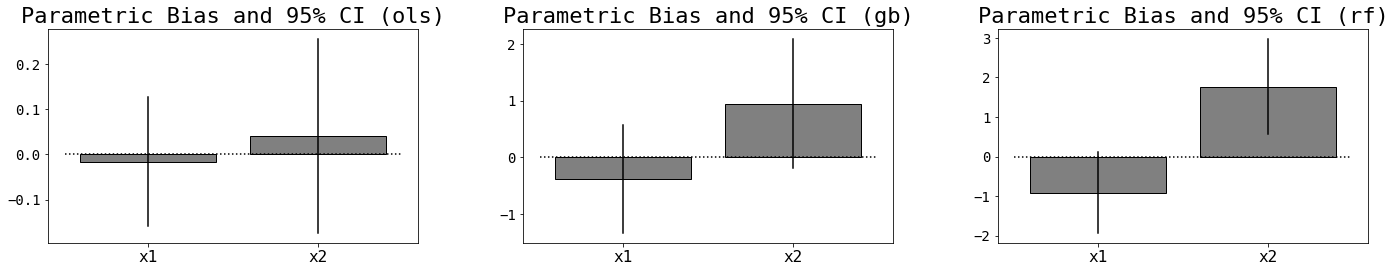

In [73]:
# Linear: Dropping outliers
fig, ax = plt.subplots(1, 3, figsize = (20,4), sharey=False)
ax, d_bm = plot_bias_mc(dict_results = dict_mc_feat_qtle, cols = ['x1','x2'], ax=ax, true_params=alpha, 
                 nonparametric=False, pmin=0.025, pmax=0.975)

## Missing Values

* Let's use MC to see the impact from missing values
* Under two assumptions: (1) missing at random, (2) missing at non-random

In [74]:
def create_missing_values(xdf, ydf, is_random=True, frac_rnd = 0.1, seed_rnd = 6651, dict_rule = False):
    """
    Creating missing values for x1:
    xdf: DataFrame with feature values
    ydf: DataFrame with outcome values
    is_random: Boolean: if True, missing at random, if False, use dict_rule
    frac_rnd: fraction of missing values to create if is_random=True
    seed_rnd: seed for the random number generator of missing if is_random=True
    dict_rule: dictionary:
        keys: ['y','x2']
        values: threshold such that key>threshold --> NaN
    """
    np.random.seed(seed_rnd)  # seed for MAR 
    new_xdf = xdf.copy()
    if is_random:
        # select some rows at random
        size = int(np.ceil(frac_rnd*xdf.shape[0]))
        loc_missing = np.random.choice(xdf.index, size=size, replace=False)
        new_xdf['x1'].loc[loc_missing] = np.nan
    else:
        col_missing = dict_rule['col']
        threshold = dict_rule['thresh']
        if col_missing == 'x2':
            loc_missing = xdf[col_missing] > threshold
        else:
            loc_missing = ydf[col_missing] > threshold
        new_xdf['x1'][loc_missing] = np.nan
            
        
    return new_xdf, loc_missing

In [75]:
# Test with a model
alpha = [2, 3.5, -5]
var_x = [3,10]
vcv_x = np.diag(var_x)
var_epsilon = 1
seed = 75010
nobs = 100
ydf, Xdf = simulate_normal_linear_model(alpha=alpha, vcv_x=vcv_x, var_epsilon=var_epsilon, 
                                        seed=seed, nobs=nobs)
# I'll try the three, always giving 20% missing

# first with MAR
xdf_rnd,_ = create_missing_values(xdf=Xdf, 
                                ydf=ydf, 
                                is_random=True, 
                                frac_rnd = 0.2, 
                                seed_rnd = 1401, 
                                dict_rule = False)
pct_mar = np.round(100*xdf_rnd.isna().mean(), decimals=1)
str_prn = f'----------- \n MAR % missing =\n{pct_mar} \n-----------'
print(str_prn)
print()
# now n-MAR: y
y_quant = ydf['y'].quantile(0.8)
dict_rule_y = {'col':'y', 'thresh':y_quant}
xdf_nmar_y ,_= create_missing_values(xdf=Xdf, 
                                ydf=ydf, 
                                is_random=False, 
                                frac_rnd = 0.1, 
                                seed_rnd = 1401, 
                                dict_rule = dict_rule_y)
pct_nmar_y = np.round(100*xdf_nmar_y.isna().mean(), decimals=1)
str_prn = f'----------- \nnon-MAR(y)% missing = \n{pct_nmar_y} \n-----------'
print(str_prn)
# now n-MAR: x2
x_quant = Xdf['x2'].quantile(0.8)
dict_rule_x = {'col':'x2', 'thresh':x_quant}
xdf_nmar_x ,_= create_missing_values(xdf=Xdf, 
                                ydf=ydf, 
                                is_random=False, 
                                frac_rnd = 0.1, 
                                seed_rnd = 1401, 
                                dict_rule = dict_rule_x)
pct_nmar_x = np.round(100*xdf_nmar_x.isna().mean(), decimals=1)
str_prn = f'----------- \nnon-MAR (x2)% missing = \n{pct_nmar_x} \n-----------'
print(str_prn)

----------- 
 MAR % missing =
x0     0.0
x1    20.0
x2     0.0
dtype: float64 
-----------

----------- 
non-MAR(y)% missing = 
x0     0.0
x1    20.0
x2     0.0
dtype: float64 
-----------
----------- 
non-MAR (x2)% missing = 
x0     0.0
x1    20.0
x2     0.0
dtype: float64 
-----------


In [76]:
def drop_nan(xdf, ydf):
    """
    Function to drop the missing values from xdf, ydf.  
        Both DFs need to keep the same rows
    Inputs:
        xdf,ydf: dataframes with features and outcome, respectively
    Outputs:
        new_x, new_y: dataframes keeping only those rows without NaNs
    """
    # if any of the columns in x,y has NaN mark the row with True
    aug_df = xdf.merge(ydf, left_index=True, right_index=True)
    loc_nan = aug_df.isna().sum(axis=1) > 0
    new_y = ydf[loc_nan==False]
    new_x = xdf[loc_nan==False]
    
    return new_x, new_y

In [77]:
# test drop_nan
test_dna = drop_nan(xdf=xdf_rnd, ydf=ydf)
print(f'Original size = {xdf_rnd.shape[0]}, \nSize after dropping = {test_dna[0].shape[0]}')
test_dna[0].isna().mean()

Original size = 100, 
Size after dropping = 80


x0    0.0
x1    0.0
x2    0.0
dtype: float64

In [78]:
def estimate_missing(xdf, name_var = 'x1'):
    """
    Use GB to estimate the missing values: x1=f(x2, other features if we have so)
        Idea: exploit correlations across features to estimate NaNs in one of the features
    Inputs:
        xdf: original dataframes with features and outcome, resp.
        name_var: feature in xdf to replace NaNs (default: 'x1')
    
    """
    hat_name = f'{name_var}_hat'  # string to save new variable
    loc_nan = xdf[name_var].isna()
    # Use remaining features to estimate x1: exploit correlation between x1 and feats
    other_cols = list(set(xdf.columns)-set(['x1']))
    feat_df = xdf[other_cols]
    out_df  = xdf[name_var]
    # drop nans and train model
    feat_df_cl, out_df_cl = drop_nan(xdf=feat_df, ydf=out_df)
    clf = GradientBoostingRegressor(random_state=1849, max_depth=3)
    clf.fit(feat_df_cl, out_df_cl)
    # use model to replace the NaNs with estimates
    predicted_x1 = pd.DataFrame(clf.predict(feat_df), columns = [hat_name], index=feat_df.index)
    newx = xdf.copy()
    newx[name_var][loc_nan] = predicted_x1[hat_name][loc_nan]
    # minimal test: no changes for those without NaNs
    test_equal = xdf['x1'][loc_nan==False] == newx[name_var][loc_nan==False]
    assert np.all(test_equal)
    
    return newx

In [79]:
test_missing = estimate_missing(xdf=xdf_rnd, name_var='x1')
test_missing.isna().mean()

x0    0.0
x1    0.0
x2    0.0
dtype: float64

In [80]:
def solve_missing(xdf, ydf, method='drop'):
    """
    Drop or replace missing values using one of two methods:
        drop: drop corresponding rows
        estimate: replace with a GB estimate for the model x1=f(x2,y)
        means: replace with the mean of each column
    Output: DF with replaced missing values or completely dropped 
        
    """
    loc_nan = xdf['x1'].isna()
    new_x = xdf.copy()
    new_y = ydf.copy()
    if method == 'drop':
        new_y = ydf[loc_nan==False]
        new_x = xdf[loc_nan==False]
    elif method == 'estimate':
        new_x = estimate_missing(xdf)
    elif method == 'means':
        new_x = new_x.fillna(value = new_x.mean())
    
    return new_x, new_y

In [81]:
test_drop = solve_missing(xdf=xdf_rnd, ydf=ydf, method='drop')
print(test_drop[0].shape,test_drop[1].shape, xdf_rnd.shape, ydf.shape)
#test_drop[0].isna().mean()

(80, 3) (80, 1) (100, 3) (100, 1)


In [82]:
def simulate_linear_with_nans(alpha, rho, var_epsilon, seed, nobs, frac_rnd, var_missing):
    """
    Simulate a linear model but create some missing values
    Inputs:
        alpha: array with K user-provided coefficients (includes intercept)
        rho: Correlation coefficient between x1, x2
        var_epsilon: variance for normal errors
        nobs: number of observations in the sample
        frac_rnd: float between 0 and 1: fraction of simulated NaNs
        var_missing: [None, 'y','x2']: variable to use as rule in dict_rule
    Outputs:
        ydf, Xdf with missing values
    """
    vcv_x = compute_vcv(rho)
    ydf, Xdf = simulate_normal_linear_model(alpha=alpha, vcv_x=vcv_x, var_epsilon=var_epsilon, 
                                        seed=seed, nobs=nobs)
    seed_rnd = 21012
    # create missing values
    is_random = False
    if var_missing is None:
        is_random = True
        quant = 'dummy'  # dummy value
        var_rule = 'dummy'  # dummy value
    elif var_missing == 'y':
        var_rule = 'y'
        quant = ydf[var_rule].quantile(1-frac_rnd)  # threshold is 1-frac_rnd quantile
    elif var_missing == 'x2':
        var_rule = 'x2'
        quant = Xdf[var_rule].quantile(1-frac_rnd)
    dict_rule = {'col' : var_rule, 'thresh' : quant}
    # Create missing values and then use a method to drop/estimate them
    xdf,_ = create_missing_values(Xdf, ydf, is_random, frac_rnd, seed_rnd, dict_rule=dict_rule)
    
    return ydf, xdf

In [83]:
alpha = [2, 3.5, -5]
rho = 0.5
var_epsilon = 1
seed = 10412
nobs = 100
frac_rnd = 0.2
var_missing = 'x2'
y_test_nan, x_test_rand = simulate_linear_with_nans(alpha, rho, var_epsilon, seed, nobs, frac_rnd, var_missing)
print(x_test_rand.isna().mean())
loc_nan = x_test_rand.x1.isna()
yx_test = x_test_rand.merge(y_test_nan, left_index = True, right_index = True)
yx_test.groupby(loc_nan).min()

x0    0.0
x1    0.2
x2    0.0
dtype: float64


,x0,x1,x2,y
x1,,,,
False,1.0,-2.732799,-2.188519,-6.412048
True,1.0,NaN,0.949840,-11.360471


In [84]:
def run_montecarlo_linear_nan(alpha, rho, var_epsilon, nobs, num_montecarlo, seed_mc, max_depth,
                          frac_rnd = 0.1, seed_rnd = 6651, var_missing = None, method='drop'):
    """
    Run a Montecarlo simulation with a linear model with missing values
    Inputs:
        alpha: array with K user-provided coefficients (includes intercept)
        rho: Correlation coefficient between x1, x2
        var_epsilon: variance for normal errors
        nobs: number of observations in the sample
        num_montecarlo: number of montecarlo samples
        seed_mc: seed for the seeds of each simulation
        max_depth: maximum depth for GB and RF models
        frac_rnd: fraction of missing values to create if is_random=True
        seed_rnd: seed for the random number generator of missing if is_random=True
        var_missing: [None, 'y','x2']: variable to use as rule in dict_rule
        method: ['drop','means','estimate'] method used to drop/fill the NaNs
    output: dict_results
        Dictionary with results from OLS, GB, RF
    """
    np.random.seed(seed_mc) # seed for generating a random seed: needed to get different samples
    seed_arr = np.random.randint(low=1, high=10000, size=num_montecarlo, dtype=int)
    K = len(alpha)
    col_labels = [f'x{num}' for num in range(K)]
    # initialize DFs to store results
    df_ols = pd.DataFrame(index = range(num_montecarlo), columns = col_labels)
    df_gb = pd.DataFrame(index = range(num_montecarlo), columns = col_labels)
    df_rf = pd.DataFrame(index = range(num_montecarlo), columns = col_labels)
    # start iteration for MC
    for i in range(num_montecarlo):
        # create linear model with missing values, and then drop/replace them
        ydf, xdf = simulate_linear_with_nans(alpha = alpha, 
                                             rho = rho, 
                                             var_epsilon = var_epsilon, 
                                             seed = seed_arr[i], 
                                             nobs = nobs, 
                                             frac_rnd = frac_rnd,
                                             var_missing = var_missing)
        xdf, ydf = solve_missing(xdf=xdf, ydf=ydf, method=method)
        # 1. OLS
        reg = LinearRegression(fit_intercept=False).fit(xdf, ydf)  # run regression
        alpha_hat = reg.coef_.flatten()
        df_ols.loc[i] = alpha_hat
        # 2 Gradient Boosting Regression
        modgb = GradientBoostingRegressor(random_state=1089, max_depth = max_depth)
        modgb.fit(xdf, ydf.values.flatten())
        df_pre_gb = compute_pdp_slope(xdf=xdf, model=modgb, drop_outliers=True,
                                     pmin=0.1, pmax=0.9)
        df_gb.loc[i] = df_pre_gb.slope.values
        # 3 Repeat for Random Forest
        modrf = RandomForestRegressor(random_state=1089, max_depth = max_depth)
        modrf.fit(xdf, ydf.values.flatten())
        df_pre_rf = compute_pdp_slope(xdf=xdf, model=modrf, drop_outliers=True,
                                     pmin=0.1, pmax=0.9)
        df_rf.loc[i] = df_pre_rf.slope.values
        
    # convert to float:
    for c, col in enumerate(col_labels):
        df_ols[col] = df_ols[col].astype('float')
        df_gb[col] = df_gb[col].astype('float')
        df_rf[col] = df_rf[col].astype('float')
    # save results in a dictionary
    dict_results = {'ols' : df_ols, 'gb' : df_gb, 'rf' : df_rf}   

    return dict_results

In [85]:
# let's try the following things
dict_settings = {'no_missing' : {'frac_rnd':0, 'method':'drop', 'var_missing':None},
                 'mar_d' : {'frac_rnd':0.1, 'method':'drop', 'var_missing':None},
                 'mar_e' : {'frac_rnd':0.1, 'method':'estimate', 'var_missing':None},
                 'mar_m' : {'frac_rnd':0.1, 'method':'means', 'var_missing':None},
                 'mar_x_d' : {'frac_rnd':0.1, 'method':'drop', 'var_missing':'x2'},
                 'mar_x_e' : {'frac_rnd':0.1, 'method':'estimate', 'var_missing':'x2'},
                 'mar_x_m' : {'frac_rnd':0.1, 'method':'means', 'var_missing':'x2'},
                 'mar_y_d' : {'frac_rnd':0.1, 'method':'drop', 'var_missing':'y'},
                 'mar_y_e' : {'frac_rnd':0.1, 'method':'estimate', 'var_missing':'y'},
                 'mar_y_m' : {'frac_rnd':0.1, 'method':'means', 'var_missing':'y'},
                }
# simulate with the following parameters
mc_size = 300
seed_mc = 8251
rho = 0.7
var_epsilon = 1
nobs = 100
max_depth = 8
frac_rnd = 0
# DF to store results
df_results_nan = pd.DataFrame(index = range(len(dict_settings)*3), columns = ['combination','algo','x1','x2'])
ix = 0
for c, comb in enumerate(dict_settings.keys()):
    # assign parameters for simulation
    dict_c = dict_settings[comb]
    frac_rnd = dict_c['frac_rnd']
    method = dict_c['method']
    var_missing = dict_c['var_missing']
    # run MC: will save in a dictionary results for 'ols','gb', 'rf'
    dict_comb = run_montecarlo_linear_nan(alpha=alpha, 
                                         rho=rho, 
                                         var_epsilon = var_epsilon, 
                                         nobs = nobs, 
                                         num_montecarlo = mc_size, 
                                         seed_mc = seed_mc, 
                                         max_depth = max_depth,
                                         frac_rnd = frac_rnd, 
                                         var_missing = var_missing, 
                                         method = method,
                                         seed_rnd = 6651, # ensure that always have same missing
                                         )
    # calculate bias
    for a, algo in enumerate(dict_comb.keys()):
        bias = (alpha - dict_comb[algo]).mean()
        bias.loc['algo'] = algo
        bias.loc['combination'] = comb
        bias = bias.loc[['combination','algo','x1','x2']]
        df_results_nan.loc[ix] = bias
        ix+=1

for col in ['x1','x2']:
    df_results_nan[col] = df_results_nan[col].astype('float')

df_res_nan_gb = df_results_nan[['x1','x2']].groupby([df_results_nan.combination, 
                                                     df_results_nan.algo]).mean().unstack()
df_res_nan_gb.head()

x1                            x2                    
algo               gb       ols        rf        gb       ols        rf
combination                                                            
mar_d        0.432053  0.004565  0.710756 -0.392619 -0.010692 -0.640553
mar_e        0.514466  0.182106  0.802604 -0.524467 -0.141815 -0.736970
mar_m        0.371015  0.327555  0.676047 -1.615509 -0.475817 -1.499935
mar_x_d      0.406669  0.012684  0.617979 -0.306809 -0.013221 -0.533365
mar_x_e      0.443569  0.238607  0.693121 -0.421804 -0.362175 -0.711680

In [86]:
# Let's use the No-Missing category as a benchmark to compute Lifts
lift_df = df_res_nan_gb.divide(df_res_nan_gb.loc['no_missing'], axis=1)
lift_df.drop('no_missing', axis=0, inplace=True)
dict_labs = {'mar_d':'MAR - dropped', 
             'mar_e':'MAR - GB', 
             'mar_m':'MAR - means', 
             'mar_x_d':'nMAR(x) - dropped', 
             'mar_x_e':'nMAR(x) - GB', 
             'mar_x_m':'nMAR(x) - means', 
             'mar_y_d':'nMAR(y) - dropped',
             'mar_y_e':'nMAR(y) - GB', 
             'mar_y_m':'nMAR(y) - means'}
# rename index with something that is more readable
lift_df.rename(index=dict_labs, inplace= True)
lift_df

x1                             x2             \
algo                     gb        ols        rf        gb        ols   
combination                                                             
MAR - dropped      1.093500   0.436669  1.082821  1.470881   0.692721   
MAR - GB           1.302083  17.419531  1.222749  1.964830   9.188354   
MAR - means        0.939017  31.332573  1.029943  6.052242  30.828655   
nMAR(x) - dropped  1.029256   1.213254  0.941477  1.149408   0.856593   
nMAR(x) - GB       1.122648  22.824102  1.055954  1.580220  23.465645   
nMAR(x) - means    0.865606  68.603473  0.897538  2.876131  78.966533   
nMAR(y) - dropped  1.317470  10.751467  1.215816  2.454299  10.369914   
nMAR(y) - GB       1.504889  27.564228  1.350335  2.383406  -8.637295   
nMAR(y) - means    1.408732  30.161963  1.184771 -0.460357  29.120889   

                             
algo                     rf  
combination                  
MAR - dropped      1.145772  
MAR - GB           1.318234  
MAR - means        2.682966  
nMAR(x) - dropped  0.954041  
nMAR(x) - GB       1.272998  
nMAR(x) - means    1.740746  
nMAR(y) - dropped  1.612487  
nMAR(y) - GB       1.473973  
nMAR(y) - means    0.150469

In [87]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """
    Truncate a colormap using LinearSegmentedColormap
    See the discussion in 
    https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
    """
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [88]:
def create_heatmap(df, ax, cmap = 'Blues', normalize = False):
    """
    Plot a heatmap of a given df
    Inputs:
        df: dataframe with data to plot
        ax: axis object to store the heatmap
        cmap: colormap for plot
        normalize: Boolean: if True: create the heatmap from normalized values
            Labels come from the unnormalized df.  But colors are created with a normalized df
            Useful for visualization purposes
    """
    #
    dfnorm = df.copy()
    if normalize:
        dfnorm = (dfnorm - dfnorm.mean())/dfnorm.std()
    cmap = plt.get_cmap(cmap)
    new_cmap = truncate_colormap(cmap=cmap, minval=0.0, maxval=0.6, n=10)
    im = ax.imshow(dfnorm, cmap = new_cmap)
    # Get ticks and labels correcly
    y_len, x_len = dfnorm.shape
    ax.set_xticks(np.arange(x_len))
    ax.set_yticks(np.arange(y_len))
    ax.set_xticklabels(dfnorm.columns, rotation = 0)
    ax.set_yticklabels(df.index)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(y_len):
        for j in range(x_len):
            text = ax.text(j, i, np.around(df.values[i, j], decimals = 2), 
                                 ha="center", va="center", color="k", fontsize = 12.,
                          weight='bold')
    return ax



Text(0.5, 1.0, 'Lift in Bias Relative to non-missing')

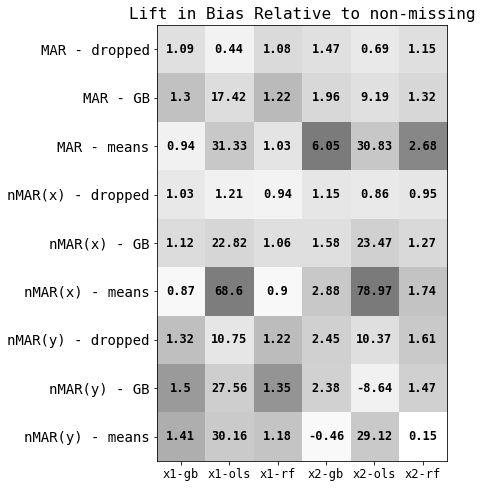

In [89]:
fig, ax = plt.subplots(figsize = (16,7))
ax = create_heatmap(df = lift_df, ax=ax, cmap = 'Greys', normalize=True)       
labs = ax.set_xticklabels([f'{col[0]}-{col[1]}' for col in lift_df.columns], rotation = 0, 
                          horizontalalignment='center', fontsize=12)
ax.set_title('Lift in Bias Relative to non-missing', fontsize=16)

# Simulate Classification Models:

* One simple way to simulate classification models is modelling _latent_ variables
* A latent variable is something we don't observe
* And we model it linearly
* To simulate a binary outcome model, we first simulate a linear latent variable and then we can divide it into bins:

Suppose that 
$$
u = \alpha_0 + \alpha_1 x_1 + \alpha_2 x_2 + \epsilon
$$

and

$$
y = \begin{cases}
0 &=& \text{if u < 0} \\
1 &=& \text{if u $\geq$ 0}
\end{cases}
$$

In [90]:
def simulate_logistic_linear_model(alpha, vcv_x, scale, nobs, seed):
    """
    Function to simulate a linear model with logistic distributed errors
    Inputs:
        alpha: array with K user-provided coefficients (includes intercept)
        vcv_x: array of dimension (K-1)x (K-1) covariance matrix for X.  Must be positive definite
        scale: scale parameter to control the variance (var = scale**2 pi**2/3)
        seed: random seed
        nobs: number of observations in the sample
    output: y,X
    """
    np.random.seed(seed)
    K = len(alpha)
    alpha = np.array(alpha).reshape((K,1))   # make it a column vector
    # simulate K-1 normal random: all mean zero (means go to the intercept so it doesn't matter)
    mu = np.array([0]*(K-1)).reshape((K-1,1))
    prex = np.random.multivariate_normal(mean=mu.flatten(), cov=vcv_x, size=nobs)
    ones = np.array([1]*nobs).reshape((nobs,1))  
    X = np.concatenate((ones, prex), axis=1) # include first the column for the intercept
    col_labels = [f'x{num}' for num in range(K)]
    xdf = pd.DataFrame(X, columns = col_labels)
    epsilon = np.random.logistic(loc=0.0, scale=scale, size=(nobs,1))
    y = np.dot(X, alpha) + epsilon
    ydf = pd.DataFrame(y, columns = ['y'])
    return ydf, xdf

In [91]:
def simulate_latent_linear(alpha, vcv_x, scale, nobs, seed):
    """
    Simulate a classification model with a linear latent variable model
    Inputs:
        alpha: array of true parameters (including intercept)
        vcv_x: variance-covariance for x1, x2 to be drawn from N(0,vcv_x)
        var_epsilon: residual variance for Normal draws epsilon~N(0,var-epsilon)
        nobs: number of observations for the model
        seed: seed for random generator
    Outputs:
        ydf: DataFrame with 1/0s according to latent variable model 
        Xdf: Dataframe with intercept, x1, x2
    """
    
    preydf, Xdf = simulate_logistic_linear_model(alpha=alpha, vcv_x=vcv_x, 
                                               scale=scale, seed=seed, nobs=nobs)
    ydf = 1*(preydf>=0)
    
    return ydf, Xdf

In [92]:
def compute_marginal_logistic(xdf, beta):
    """
    Compute the marginal effect array for a logistic model
        Evaluated on the means
        Mg. Eff = beta*pdf(xbeta)
    """
    # compute the means
    beta_arr = np.array(beta)
    means = xdf.mean()
    xbeta = np.dot(means, beta_arr)
    numerator = np.exp(xbeta)
    denominator = (1+np.exp(xbeta))**2
    frac = numerator/denominator
    # marginal effect
    mg_eff = beta_arr*frac
    return mg_eff


In [93]:
def run_montecarlo_linear_class(alpha, vcv_x, scale, nobs, num_montecarlo, seed_mc, max_depth):
    """
    MC simulation for a linear classification model using logistic latent variable:
        I estimate three models: linear probability (OLS), logistic, gradient boosting classifier
        For the logistic I report the coefficients and the marginal effects
    Inputs:
        alpha: array: true parameters for linear latent variable model
        vcv_x: cov matrix for x1,x2 to be drawn N(0,vcv_x)
        scale: scale parameter for logistically dist. residuals in the latent variable model
        nobs: number of observations in each each MC sample
        num_montecarlo: number of simulations
        seed_mc: seed for random number generator used in each MC simulation
        max_depth: maximum depth for vanilla Gradient Boosting Classifier
     """
    
    np.random.seed(seed_mc) # seed for generating a random seed: needed to get different samples
    seed_arr = np.random.randint(low=1, high=10000, size=num_montecarlo, dtype=int)
    K = len(alpha)
    col_labels = [f'x{num}' for num in range(K)]
    # initialize DFs to store results
    df_linprob = pd.DataFrame(index = range(num_montecarlo), columns = col_labels)
    df_logistic = pd.DataFrame(index = range(num_montecarlo), columns = col_labels)
    df_log_mrg = pd.DataFrame(index = range(num_montecarlo), columns = col_labels)
    df_gbc = pd.DataFrame(index = range(num_montecarlo), columns = col_labels)
    for i in range(num_montecarlo):
        # simulate model
        ydf, Xdf = simulate_latent_linear(alpha=alpha, vcv_x=vcv_x, scale=scale, 
                                            seed=seed_arr[i], nobs=nobs)
        yval = ydf.values.flatten()
        # 1. Run Logistic regression
        reg = LogisticRegression(fit_intercept=False, random_state=0).fit(Xdf, yval)
        alpha_logistic = reg.coef_.flatten()
        df_logistic.loc[i] = alpha_logistic
        # 1b. Calculate marginal effect to compare with linear probability model
        mg_eff = compute_marginal_logistic(xdf=Xdf, beta=alpha_logistic)
        df_log_mrg.loc[i] = mg_eff
        # 2. Run Linear Probability model
        reglin = LinearRegression(fit_intercept=False).fit(Xdf, yval)
        alpha_linear = reglin.coef_.flatten()
        df_linprob.loc[i] = alpha_linear
        # 3. Gradient boosting classifer
        gbc = GradientBoostingClassifier(max_depth=max_depth, random_state=1588).fit(Xdf, yval)
        slope = compute_pdp_slope(xdf=Xdf, 
                                  model=gbc, 
                                  drop_outliers=True, 
                                  pmin=0.01, 
                                  pmax=0.99)
        df_gbc.loc[i] = slope.values.flatten()
        
    # convert to float:
    for c, col in enumerate(col_labels):
        df_linprob[col] = df_linprob[col].astype('float')
        df_logistic[col] = df_logistic[col].astype('float')
        df_log_mrg[col] = df_log_mrg[col].astype('float')
        df_gbc[col] = df_gbc[col].astype('float')
    # save in a dictionary
    dict_results = {'logistic' : df_logistic, 
                     'logistic_me' : df_log_mrg,
                    'linprob' : df_linprob,                    
                    'gbc' : df_gbc,                    
                   }
        
    return dict_results

In [106]:
# Now let's get a real model
alpha = [2, 3.5, -5]
vcv_x = np.diag([1,1])
scale = 1
variance = (scale**2)*(np.pi**2)/3 # variance for a logistic distribution with scale
alpha_norm = np.array(alpha)/np.sqrt(variance)  # normalized true coefficients
seed = 22701
nobs = 100
max_depth = 3
num_montecarlo=300
seed_mc = 22701
# Let's see what I estimate with LogisticRegression
dict_test_lat = run_montecarlo_linear_class(alpha = alpha, 
                                            vcv_x = vcv_x, 
                                            scale = scale, 
                                            nobs = nobs, 
                                            num_montecarlo = num_montecarlo, 
                                            seed_mc = seed_mc,
                                            max_depth = max_depth)
print(f'Normalized parameters = {alpha_norm}')
# compute means of estimated parameters in logistic
means_logistic = dict_test_lat['logistic'].mean().values
print(f'Estimated normalized parameters = {means_logistic}')

Normalized parameters = [ 1.10265779  1.92965113 -2.75664448]
Estimated normalized parameters = [ 1.01610439  1.79162908 -2.57975574]


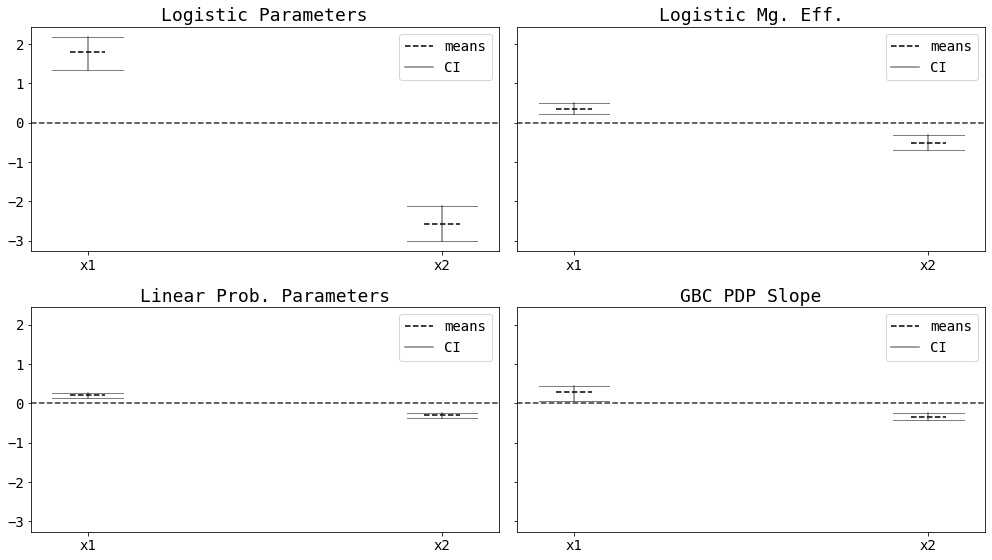

In [95]:
ncols = 2
nrows = 2
fig, ax = plt.subplots(2,2, figsize = (14,8),sharey = True)
dict_title = {'logistic' : 'Logistic Parameters', 
              'logistic_me' : 'Logistic Mg. Eff.',
              'linprob' : 'Linear Prob. Parameters',
              'gbc' : 'GBC PDP Slope'}
for k, key in enumerate(dict_test_lat.keys()):
    ix_row = k//ncols
    ix_col = k%ncols
    ax_k = ax[ix_row, ix_col]
    df_k = dict_test_lat[key]
    df_k = df_k[['x1','x2']]
    bounds_sn = create_means_bounds_mc(df=df_k, qmin=0.025, qmax=0.975)
    means = bounds_sn.loc['mean']
    ind_ptile = [ind for ind in bounds_sn.index if ind.find('percentile') >= 0]
    bounds = bounds_sn.loc[ind_ptile].values
    var_labels = bounds_sn.columns
    ax_k = plot_conf_intervals(means=means, bounds=bounds, var_labels=var_labels, ax=ax_k, 
                               true_params=None,
                            plot_bars=False)
    #ax_k
    title = ax_k.set_title(dict_title[key], fontsize = 18)

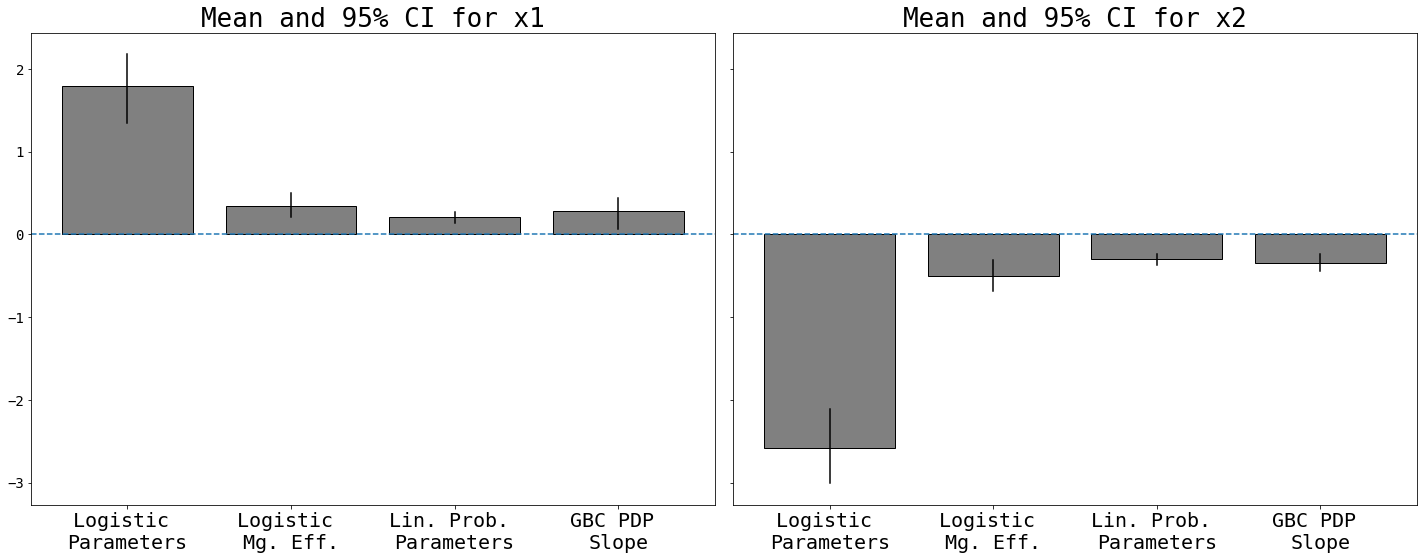

In [96]:
# Previous plot isn't clear enough: let's try something else

fig, ax = plt.subplots(1,2, figsize = (20,8),sharey = True) 
dict_title = {'logistic' : 'Logistic \nParameters', 
              'logistic_me' : 'Logistic \nMg. Eff.',
              'linprob' : 'Lin. Prob. \nParameters',
              'gbc' : 'GBC PDP \nSlope'}
for i in range(2):
    ax_i = ax[i]
    ctr_i = i+1
    col = f'x{ctr_i}'
    for k, key in enumerate(dict_test_lat.keys()):
        df_k = dict_test_lat[key]
        df_k = df_k[col]
        qmax = 0.975
        qmin = 1-qmax
        ci_str = int((1-2*qmin)*100)
        bounds_sn = create_means_bounds_mc(df=df_k, qmin=qmin, qmax=qmax)
        means = bounds_sn.loc['mean']
        ind_ptile = [ind for ind in bounds_sn.index if ind.find('percentile') >= 0]
        bounds = bounds_sn.loc[ind_ptile].values
        ax_i.bar(k, means, edgecolor='k', facecolor='0.5')
        ax_i.plot([k,k],bounds, color = 'k')
    xmin, xmax = ax_i.get_xlim()
    ax_i.plot([xmin, xmax], [0,0], ls='--')
    ax_i.set_xlim([xmin, xmax])
    ax_i.set_xticks(range(4))
    ax_i.set_xticklabels([dict_title[key] for key in dict_test_lat.keys()],
                        fontsize = 20, rotation=0)
    title = ax_i.set_title(f'Mean and {ci_str}% CI for {col}', fontsize=26)

# Bootstrapping CI

* Bootstrapping is similar to MC simulation.
* It's especially useful when you want to estimate the variance or CI for a metric
* Here I'll bootstrap CI for True Positive Rates by Decile

In [97]:
def calculate_tpr_ptile(ydf, xdf, model, ntiles = 10):
    """Calculate true positive rate by quantiles for a classification model
        This function can be used to calculate deciles, quintiles or the like
    Inputs:
        ydf, xdf: dataframes with outcome and features used in training
        model: model object from scikit-learn (should have a predict_proba method)
        ntiles: number of quantiles to use (default: deciles)
    """
    qtiles = np.linspace(0,1,ntiles+1)
    df_score = pd.DataFrame(model.predict_proba(xdf)[:,1], columns=['score'])
    labels = [f'q{d}' for d,dec in enumerate(qtiles)]
    df_score['quantiles'] = pd.qcut(x=df_score.score, q = qtiles, labels=labels[1:])
    df_score['observed'] = ydf
    # calculate tpr by decile
    tpr_dec = 100*df_score.observed.groupby(df_score.quantiles).mean()
    return tpr_dec

Text(0, 0.5, '%')

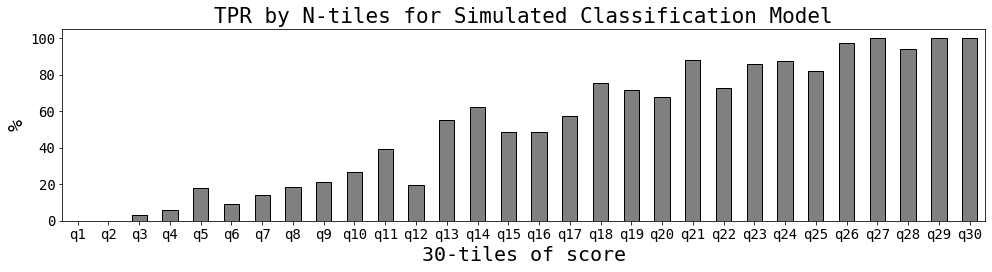

In [98]:
# simulate a classification model
nobs = 1000
seed = 8261
rho = 0.8
vcv_x = compute_vcv(rho)
scale = 100
ydf, Xdf = simulate_latent_linear(alpha=alpha, vcv_x=vcv_x, scale=scale, 
                                    seed=seed, nobs=nobs)
max_depth = 3
gbc = GradientBoostingClassifier(max_depth=max_depth, random_state=1588).fit(Xdf, ydf.values.flatten())

# calculate tpr
ntiles = 30
tpr_dec = calculate_tpr_ptile(ydf=ydf, xdf=Xdf, model=gbc, ntiles = ntiles)
fig, ax = plt.subplots(figsize = (14,4))
tpr_dec.plot(kind='bar', edgecolor='k', facecolor='0.5')
labs = ax.set_xticklabels(tpr_dec.index, rotation = 0)
ax.set_title('TPR by N-tiles for Simulated Classification Model', fontsize = 21)
ax.set_xlabel(f'{ntiles}-tiles of score')
ax.set_ylabel('%')

In [99]:
def bootstrap_tpr(ydf, xdf, model, ntiles, boot_samples=300, ci_length=0.95):
    """
    Calculate ci_length% CI for tpr by deciles using bootstrapping
    Inputs:
        ydf, xdf: dataframes where you want the TPR to be evaluated (could be your test sample)
        model: scikitlearn model object to make probability score predictions (must have predict_proba method)
        ntiles: number of percentiles to use
        boot_samples: number of bootstrap samples to use
        ci_length: size of the CI: default - 95% 
    Output
        df_boot: Dataframe with 10 columns (1 per decile) and two rows corresponding to the bounds of the CI
    """
    cols = [f'q{d}' for d,dec in enumerate(np.linspace(0,1,ntiles+1))]
    cols = cols[1:]
    df_boot_pre = pd.DataFrame(index=range(boot_samples), columns = cols, dtype = 'float')
    nobs = ydf.shape[0]
    for b in range(boot_samples):
        # make a random draw with replacement of the same size as original dataset
        ix_b = np.random.choice(ydf.index, size=nobs, replace=True)
        y_b = ydf.loc[ix_b].values.flatten()
        x_b = xdf.loc[ix_b]
        tpr_b = calculate_tpr_ptile(ydf=y_b, xdf=x_b, model=model, ntiles = ntiles)
        df_boot_pre.loc[b] = tpr_b
    # I can now compute CI
    pmax = 1-(1 - ci_length)/2
    pmin = (1 - ci_length)/2
    df_boot = df_boot_pre.quantile([pmin, pmax])
    df_boot_mean = df_boot_pre.mean()
    
    return df_boot, df_boot_mean

In [100]:
def plot_boot_ci_tpr(ydf, xdf, model, ntiles, boot_samples, ci_length, ax):
    "plot the TPR and bootstrap confidence intervals"
    bounds, mean = bootstrap_tpr(ydf=ydf, 
                                 xdf=xdf, 
                                 model=model, 
                                 ntiles=ntiles, 
                                 boot_samples=boot_samples, 
                                 ci_length=ci_length)
    ax.bar(range(ntiles), mean.values, edgecolor='k', facecolor='0.7')
    ax.set_xticks(range(ntiles))
    labs = ax.set_xticklabels(bounds.columns, rotation = 0, fontsize = 16)
    for c, col in enumerate(bounds.columns):
        ix_min = bounds.index[0]
        ix_max = bounds.index[1]
        ax.plot([c,c], [bounds[col].loc[ix_min], bounds[col].loc[ix_max]], color='k')
    ax.set_title(f'TPR by {ntiles}-tile and 95% CI')
    ax.set_ylabel('%')
    ax.set_xlabel(f'{ntiles}-tiles')    
    return ax

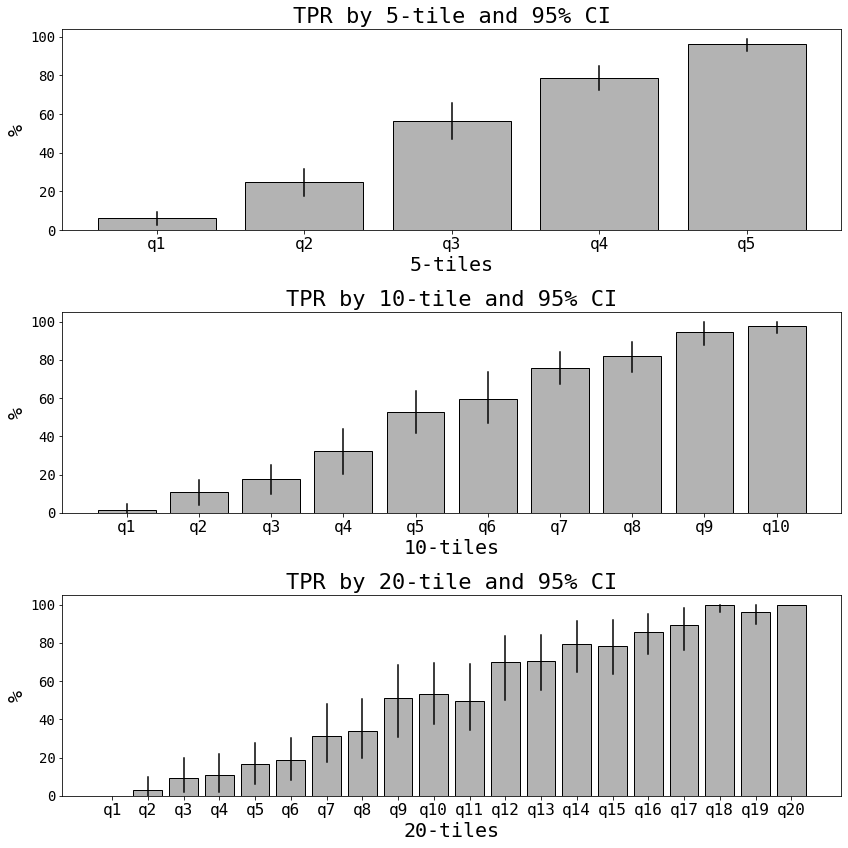

In [101]:
fig, ax = plt.subplots(3,1,figsize=(12,12))
ntile_grid = [5,10,20]
boot_samples = 300
for n, ntle in enumerate(ntile_grid):
    ax[n] = plot_boot_ci_tpr(ydf=ydf, xdf=Xdf, model=gbc, ntiles=ntle, boot_samples=boot_samples, 
                          ci_length=0.95, ax=ax[n])